In [1]:
import sys
import cv2 
import pickle
from PIL import Image
import pandas as pd
import numpy as np
import mtcnn
from mtcnn.mtcnn import MTCNN

In [2]:
from matplotlib.patches import Rectangle

In [3]:
from matplotlib import pyplot as plt

In [4]:
im=Image.open('yalefaces/subject03.happy')

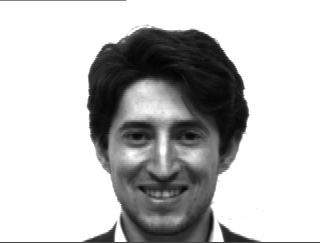

In [5]:
im

^C
Note: you may need to restart the kernel to use updated packages.


In [6]:
rgb_pixels = np.stack((im, im, im), axis=2)

(243, 320, 3)


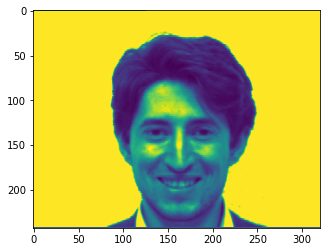

In [7]:
print(rgb_pixels.shape)
plt.imshow(im)
plt.show()

In [8]:
# Create the detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(rgb_pixels)

1/1 [==============================] - 0s 117ms/step


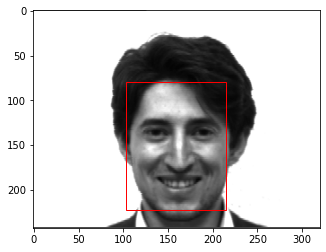

In [9]:
def draw_image_with_boxes(data, result_list):
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()

# display faces on the original image
draw_image_with_boxes(rgb_pixels, results)

1/1 [==============================] - 0s 114ms/step


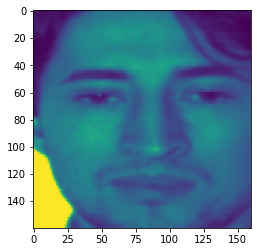

In [10]:
# extract a single face from a given photograph
def extract_face_from_file(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    
    return extract_face(image, required_size)

def extract_face(image, required_size=(160, 160)):
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    
    return gray_face


# Create the detector, using default weights
detector = MTCNN()

# load the photo and extract the face
face_pixels = extract_face_from_file("yalefaces/subject03.centerlight")

plt.imshow(face_pixels)

In [58]:
from os import listdir
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)
data="yalefaces"

# list filenames
filenames = pd.DataFrame(list_files(data, "subject"))

# generate split 
df = filenames[0].str.split(".", expand=True)
df["filename"] = filenames

# # tidy columns
df = df.rename(columns = {0:"subject", 1:"category"})
df['subject'] = df.subject.str.replace('subject' , '')
df.apply(pd.to_numeric, errors='coerce').dropna()
df['subject'] = pd.to_numeric(df["subject"])
df

,subject,category,2,filename
0,1,gif,None,subject01.gif
1,1,glasses,None,subject01.glasses
2,1,glasses,gif,subject01.glasses.gif
3,1,happy,None,subject01.happy
4,1,leftlight,None,subject01.leftlight
...,...,...,...,...
161,15,rightlight,None,subject15.rightlight
162,15,sad,None,subject15.sad
163,15,sleepy,None,subject15.sleepy
164,15,surprised,None,subject15.surprised


In [13]:
df['subject'].unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [16]:
from sklearn.model_selection import train_test_split
PER_CLASS = 8 # 11 images (3 test & 8 train)
NO_CLASSES = 15
DS_SIZE = df["subject"].count()
TEST_SIZE = 1 - (PER_CLASS * NO_CLASSES / DS_SIZE)

# # list files for each group
# # df.groupby(['subject'])['filename'].apply(list)
y = df['subject']
X = df.drop('subject',axis=1)

# # subject
X_train_info, X_test_info, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=45, stratify=y)

y_train = y_train.tolist()
y_test = y_test.tolist()

pandas.core.series.Series

In [21]:
X_train_info

,category,2,filename
126,noglasses,None,subject12.noglasses
156,glasses,None,subject15.glasses
109,surprised,None,subject10.surprised
136,leftlight,None,subject13.leftlight
150,rightlight,None,subject14.rightlight
...,...,...,...
83,normal,None,subject08.normal
99,wink,None,subject09.wink
40,rightlight,None,subject04.rightlight
147,leftlight,None,subject14.leftlight


In [27]:
from tqdm import tqdm
def load_dataset(dataset):
    faces = list()
    for filename in tqdm(dataset["filename"]):
        s="/"
        path = data +s+ filename
        print(path)
        # get face
        face = extract_face_from_file(path)
        faces.append(face)
    return np.asarray(faces)

In [28]:
X_test = load_dataset(X_test_info)
X_train = load_dataset(X_train_info)

print(X_test.shape)
print(X_train.shape)

  0%|                                                                                           | 0/46 [00:00<?, ?it/s]

yalefaces/subject12.leftlight
1/1 [==============================] - 0s 19ms/step


  2%|█▊                                                                                 | 1/46 [00:00<00:26,  1.70it/s]

yalefaces/subject03.wink
1/1 [==============================] - 0s 18ms/step


  4%|███▌                                                                               | 2/46 [00:01<00:25,  1.71it/s]

yalefaces/subject11.wink
1/1 [==============================] - 0s 23ms/step


  7%|█████▍                                                                             | 3/46 [00:01<00:24,  1.75it/s]

yalefaces/subject12.happy
1/1 [==============================] - 0s 18ms/step


  9%|███████▏                                                                           | 4/46 [00:02<00:23,  1.78it/s]

yalefaces/subject02.rightlight
1/1 [==============================] - 0s 20ms/step


 11%|█████████                                                                          | 5/46 [00:02<00:23,  1.74it/s]

yalefaces/subject04.sad
1/1 [==============================] - 0s 17ms/step


 13%|██████████▊                                                                        | 6/46 [00:03<00:22,  1.77it/s]

yalefaces/subject15.sad
1/1 [==============================] - 0s 20ms/step


 15%|████████████▋                                                                      | 7/46 [00:04<00:24,  1.59it/s]

yalefaces/subject11.leftlight
1/1 [==============================] - 0s 29ms/step


 17%|██████████████▍                                                                    | 8/46 [00:04<00:23,  1.62it/s]

yalefaces/subject04.surprised
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▏                                                                  | 9/46 [00:05<00:21,  1.69it/s]

yalefaces/subject14.happy
1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▊                                                                | 10/46 [00:05<00:21,  1.66it/s]

yalefaces/subject10.leftlight
1/1 [==============================] - 0s 22ms/step


 24%|███████████████████▌                                                              | 11/46 [00:06<00:20,  1.72it/s]

yalefaces/subject02.noglasses
1/1 [==============================] - 0s 28ms/step


 26%|█████████████████████▍                                                            | 12/46 [00:07<00:19,  1.74it/s]

yalefaces/subject13.surprised
1/1 [==============================] - 0s 17ms/step


 28%|███████████████████████▏                                                          | 13/46 [00:07<00:18,  1.75it/s]

yalefaces/subject03.rightlight
1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████▉                                                         | 14/46 [00:08<00:18,  1.72it/s]

yalefaces/subject03.centerlight
1/1 [==============================] - 0s 32ms/step


 33%|██████████████████████████▋                                                       | 15/46 [00:08<00:17,  1.74it/s]

yalefaces/subject06.sad
1/1 [==============================] - 0s 32ms/step


 35%|████████████████████████████▌                                                     | 16/46 [00:09<00:17,  1.73it/s]

yalefaces/subject01.noglasses
1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▎                                                   | 17/46 [00:09<00:17,  1.70it/s]

yalefaces/subject08.sad
1/1 [==============================] - 0s 25ms/step


 39%|████████████████████████████████                                                  | 18/46 [00:10<00:16,  1.75it/s]

yalefaces/subject05.surprised
1/1 [==============================] - 0s 17ms/step


 41%|█████████████████████████████████▊                                                | 19/46 [00:11<00:15,  1.72it/s]

yalefaces/subject09.happy
1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████▋                                              | 20/46 [00:11<00:15,  1.73it/s]

yalefaces/subject14.glasses
1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████▍                                            | 21/46 [00:12<00:14,  1.71it/s]

yalefaces/subject14.noglasses
1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████▏                                          | 22/46 [00:12<00:13,  1.73it/s]

yalefaces/subject07.leftlight
1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 23/46 [00:13<00:13,  1.76it/s]

yalefaces/subject13.glasses
1/1 [==============================] - 0s 31ms/step


 52%|██████████████████████████████████████████▊                                       | 24/46 [00:14<00:13,  1.69it/s]

yalefaces/subject05.centerlight
1/1 [==============================] - 0s 24ms/step


 54%|████████████████████████████████████████████▌                                     | 25/46 [00:14<00:12,  1.73it/s]

yalefaces/subject01.wink
1/1 [==============================] - 0s 23ms/step


 57%|██████████████████████████████████████████████▎                                   | 26/46 [00:15<00:11,  1.67it/s]

yalefaces/subject02.glasses
1/1 [==============================] - 0s 20ms/step


 59%|████████████████████████████████████████████████▏                                 | 27/46 [00:15<00:11,  1.66it/s]

yalefaces/subject07.happy
1/1 [==============================] - 0s 117ms/step


 61%|█████████████████████████████████████████████████▉                                | 28/46 [00:16<00:11,  1.60it/s]

yalefaces/subject09.sad
1/1 [==============================] - 0s 42ms/step


 63%|███████████████████████████████████████████████████▋                              | 29/46 [00:17<00:13,  1.22it/s]

yalefaces/subject15.rightlight
1/1 [==============================] - 0s 48ms/step


 65%|█████████████████████████████████████████████████████▍                            | 30/46 [00:18<00:14,  1.07it/s]

yalefaces/subject08.wink
1/1 [==============================] - 0s 55ms/step


 67%|███████████████████████████████████████████████████████▎                          | 31/46 [00:20<00:15,  1.01s/it]

yalefaces/subject07.surprised
1/1 [==============================] - 0s 46ms/step


 70%|█████████████████████████████████████████████████████████                         | 32/46 [00:21<00:14,  1.06s/it]

yalefaces/subject12.surprised
1/1 [==============================] - 0s 50ms/step


 72%|██████████████████████████████████████████████████████████▊                       | 33/46 [00:22<00:14,  1.10s/it]

yalefaces/subject01.glasses.gif
1/1 [==============================] - 0s 48ms/step


 74%|████████████████████████████████████████████████████████████▌                     | 34/46 [00:23<00:13,  1.12s/it]

yalefaces/subject09.rightlight
1/1 [==============================] - 0s 39ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 35/46 [00:24<00:12,  1.14s/it]

yalefaces/subject06.sleepy
1/1 [==============================] - 0s 55ms/step


 78%|████████████████████████████████████████████████████████████████▏                 | 36/46 [00:26<00:11,  1.16s/it]

yalefaces/subject15.leftlight
1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▉                | 37/46 [00:27<00:10,  1.16s/it]

yalefaces/subject10.centerlight
1/1 [==============================] - 0s 52ms/step


 83%|███████████████████████████████████████████████████████████████████▋              | 38/46 [00:28<00:09,  1.19s/it]

yalefaces/subject11.sad
1/1 [==============================] - 0s 57ms/step


 85%|█████████████████████████████████████████████████████████████████████▌            | 39/46 [00:29<00:08,  1.21s/it]

yalefaces/subject06.normal
1/1 [==============================] - 0s 57ms/step


 87%|███████████████████████████████████████████████████████████████████████▎          | 40/46 [00:31<00:07,  1.22s/it]

yalefaces/subject13.sad
1/1 [==============================] - 0s 42ms/step


 89%|█████████████████████████████████████████████████████████████████████████         | 41/46 [00:32<00:06,  1.20s/it]

yalefaces/subject10.rightlight
1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▊       | 42/46 [00:33<00:04,  1.19s/it]

yalefaces/subject05.rightlight
1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▋     | 43/46 [00:34<00:03,  1.19s/it]

yalefaces/subject01.sad
1/1 [==============================] - 0s 60ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 44/46 [00:35<00:02,  1.20s/it]

yalefaces/subject04.centerlight
1/1 [==============================] - 0s 51ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 45/46 [00:36<00:01,  1.18s/it]

yalefaces/subject08.happy
1/1 [==============================] - 0s 47ms/step


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

yalefaces/subject12.noglasses
1/1 [==============================] - 0s 40ms/step


  1%|▋                                                                                 | 1/120 [00:01<02:18,  1.16s/it]

yalefaces/subject15.glasses
1/1 [==============================] - 0s 50ms/step


  2%|█▎                                                                                | 2/120 [00:02<02:18,  1.17s/it]

yalefaces/subject10.surprised
1/1 [==============================] - 0s 54ms/step


  2%|██                                                                                | 3/120 [00:03<02:18,  1.18s/it]

yalefaces/subject13.leftlight
1/1 [==============================] - 0s 40ms/step


  3%|██▋                                                                               | 4/120 [00:04<02:16,  1.17s/it]

yalefaces/subject14.rightlight
1/1 [==============================] - 0s 54ms/step


  4%|███▍                                                                              | 5/120 [00:05<02:14,  1.17s/it]

yalefaces/subject10.glasses
1/1 [==============================] - 0s 49ms/step


  5%|████                                                                              | 6/120 [00:07<02:13,  1.17s/it]

yalefaces/subject01.leftlight
1/1 [==============================] - 0s 48ms/step


  6%|████▊                                                                             | 7/120 [00:08<02:11,  1.17s/it]

yalefaces/subject09.leftlight
1/1 [==============================] - 0s 49ms/step


  7%|█████▍                                                                            | 8/120 [00:09<02:11,  1.17s/it]

yalefaces/subject12.sad
1/1 [==============================] - 0s 41ms/step


  8%|██████▏                                                                           | 9/120 [00:10<02:09,  1.17s/it]

yalefaces/subject15.centerlight
1/1 [==============================] - 0s 48ms/step


  8%|██████▊                                                                          | 10/120 [00:11<02:08,  1.17s/it]

yalefaces/subject06.centerlight
1/1 [==============================] - 0s 52ms/step


  9%|███████▍                                                                         | 11/120 [00:12<02:06,  1.16s/it]

yalefaces/subject02.centerlight
1/1 [==============================] - 0s 49ms/step


 10%|████████                                                                         | 12/120 [00:13<02:04,  1.16s/it]

yalefaces/subject10.sad
1/1 [==============================] - 0s 57ms/step


 11%|████████▊                                                                        | 13/120 [00:15<02:04,  1.17s/it]

yalefaces/subject12.glasses
1/1 [==============================] - 0s 49ms/step


 12%|█████████▍                                                                       | 14/120 [00:16<02:03,  1.16s/it]

yalefaces/subject12.sleepy
1/1 [==============================] - 0s 48ms/step


 12%|██████████▏                                                                      | 15/120 [00:17<02:02,  1.17s/it]

yalefaces/subject09.surprised
1/1 [==============================] - 0s 40ms/step


 13%|██████████▊                                                                      | 16/120 [00:18<02:00,  1.16s/it]

yalefaces/subject09.noglasses
1/1 [==============================] - 0s 57ms/step


 14%|███████████▍                                                                     | 17/120 [00:19<01:59,  1.16s/it]

yalefaces/subject01.surprised
1/1 [==============================] - 0s 42ms/step


 15%|████████████▏                                                                    | 18/120 [00:20<01:58,  1.16s/it]

yalefaces/subject05.sad
1/1 [==============================] - 0s 53ms/step


 16%|████████████▊                                                                    | 19/120 [00:22<01:57,  1.16s/it]

yalefaces/subject06.leftlight
1/1 [==============================] - 0s 39ms/step


 17%|█████████████▌                                                                   | 20/120 [00:23<01:56,  1.16s/it]

yalefaces/subject03.normal
1/1 [==============================] - 0s 51ms/step


 18%|██████████████▏                                                                  | 21/120 [00:24<01:55,  1.16s/it]

yalefaces/subject11.happy
1/1 [==============================] - 0s 47ms/step


 18%|██████████████▊                                                                  | 22/120 [00:25<01:53,  1.16s/it]

yalefaces/subject11.rightlight
1/1 [==============================] - 0s 45ms/step


 19%|███████████████▌                                                                 | 23/120 [00:26<01:52,  1.16s/it]

yalefaces/subject03.surprised
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▏                                                                | 24/120 [00:27<01:51,  1.16s/it]

yalefaces/subject04.happy
1/1 [==============================] - 0s 49ms/step


 21%|████████████████▉                                                                | 25/120 [00:29<01:50,  1.16s/it]

yalefaces/subject05.glasses
1/1 [==============================] - 0s 44ms/step


 22%|█████████████████▌                                                               | 26/120 [00:30<01:48,  1.16s/it]

yalefaces/subject07.rightlight
1/1 [==============================] - 0s 51ms/step


 22%|██████████████████▏                                                              | 27/120 [00:31<01:48,  1.16s/it]

yalefaces/subject12.centerlight
1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▉                                                              | 28/120 [00:32<01:46,  1.16s/it]

yalefaces/subject14.surprised
1/1 [==============================] - 0s 44ms/step


 24%|███████████████████▌                                                             | 29/120 [00:33<01:45,  1.16s/it]

yalefaces/subject01.gif
1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▎                                                            | 30/120 [00:34<01:43,  1.15s/it]

yalefaces/subject15.normal
1/1 [==============================] - 0s 40ms/step


 26%|████████████████████▉                                                            | 31/120 [00:36<01:42,  1.15s/it]

yalefaces/subject10.wink
1/1 [==============================] - 0s 55ms/step


 27%|█████████████████████▌                                                           | 32/120 [00:37<01:41,  1.15s/it]

yalefaces/subject03.sad
1/1 [==============================] - 0s 54ms/step


 28%|██████████████████████▎                                                          | 33/120 [00:38<01:40,  1.16s/it]

yalefaces/subject04.sleepy
1/1 [==============================] - 0s 49ms/step


 28%|██████████████████████▉                                                          | 34/120 [00:39<01:40,  1.17s/it]

yalefaces/subject02.normal
1/1 [==============================] - 0s 40ms/step


 29%|███████████████████████▋                                                         | 35/120 [00:40<01:38,  1.16s/it]

yalefaces/subject01.rightlight
1/1 [==============================] - 0s 56ms/step


 30%|████████████████████████▎                                                        | 36/120 [00:41<01:37,  1.16s/it]

yalefaces/subject11.glasses
1/1 [==============================] - 0s 50ms/step


 31%|████████████████████████▉                                                        | 37/120 [00:43<01:36,  1.16s/it]

yalefaces/subject02.sleepy
1/1 [==============================] - 0s 44ms/step


 32%|█████████████████████████▋                                                       | 38/120 [00:44<01:35,  1.17s/it]

yalefaces/subject11.sleepy
1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████▎                                                      | 39/120 [00:45<01:34,  1.17s/it]

yalefaces/subject14.normal
1/1 [==============================] - 0s 48ms/step


 33%|███████████████████████████                                                      | 40/120 [00:46<01:32,  1.16s/it]

yalefaces/subject13.sleepy
1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▋                                                     | 41/120 [00:47<01:31,  1.15s/it]

yalefaces/subject06.surprised
1/1 [==============================] - 0s 65ms/step


 35%|████████████████████████████▎                                                    | 42/120 [00:48<01:29,  1.15s/it]

yalefaces/subject04.glasses
1/1 [==============================] - 0s 56ms/step


 36%|█████████████████████████████                                                    | 43/120 [00:49<01:29,  1.16s/it]

yalefaces/subject03.glasses
1/1 [==============================] - 0s 50ms/step


 37%|█████████████████████████████▋                                                   | 44/120 [00:51<01:27,  1.16s/it]

yalefaces/subject06.wink
1/1 [==============================] - 0s 49ms/step


 38%|██████████████████████████████▍                                                  | 45/120 [00:52<01:35,  1.27s/it]

yalefaces/subject04.wink
1/1 [==============================] - 0s 48ms/step


 38%|███████████████████████████████                                                  | 46/120 [00:53<01:31,  1.24s/it]

yalefaces/subject11.surprised
1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                 | 47/120 [00:54<01:28,  1.22s/it]

yalefaces/subject02.sad
1/1 [==============================] - 0s 49ms/step


 40%|████████████████████████████████▍                                                | 48/120 [00:56<01:26,  1.20s/it]

yalefaces/subject03.leftlight
1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████                                                | 49/120 [00:57<01:24,  1.19s/it]

yalefaces/subject02.happy
1/1 [==============================] - 0s 53ms/step


 42%|█████████████████████████████████▊                                               | 50/120 [00:58<01:22,  1.18s/it]

yalefaces/subject01.normal
1/1 [==============================] - 0s 50ms/step


 42%|██████████████████████████████████▍                                              | 51/120 [00:59<01:20,  1.17s/it]

yalefaces/subject14.sleepy
1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████                                              | 52/120 [01:00<01:19,  1.17s/it]

yalefaces/subject01.sleepy
1/1 [==============================] - 0s 59ms/step


 44%|███████████████████████████████████▊                                             | 53/120 [01:01<01:19,  1.19s/it]

yalefaces/subject06.glasses
1/1 [==============================] - 0s 53ms/step


 45%|████████████████████████████████████▍                                            | 54/120 [01:03<01:18,  1.19s/it]

yalefaces/subject08.sleepy
1/1 [==============================] - 0s 48ms/step


 46%|█████████████████████████████████████▏                                           | 55/120 [01:04<01:16,  1.18s/it]

yalefaces/subject07.normal
1/1 [==============================] - 0s 48ms/step


 47%|█████████████████████████████████████▊                                           | 56/120 [01:05<01:15,  1.18s/it]

yalefaces/subject05.noglasses
1/1 [==============================] - 0s 52ms/step


 48%|██████████████████████████████████████▍                                          | 57/120 [01:06<01:14,  1.18s/it]

yalefaces/subject07.wink
1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                         | 58/120 [01:07<01:13,  1.18s/it]

yalefaces/subject10.noglasses
1/1 [==============================] - 0s 43ms/step


 49%|███████████████████████████████████████▊                                         | 59/120 [01:09<01:12,  1.19s/it]

yalefaces/subject07.centerlight
1/1 [==============================] - 0s 50ms/step


 50%|████████████████████████████████████████▌                                        | 60/120 [01:10<01:10,  1.18s/it]

yalefaces/subject08.glasses
1/1 [==============================] - 0s 51ms/step


 51%|█████████████████████████████████████████▏                                       | 61/120 [01:11<01:09,  1.18s/it]

yalefaces/subject13.noglasses
1/1 [==============================] - 0s 51ms/step


 52%|█████████████████████████████████████████▊                                       | 62/120 [01:12<01:08,  1.18s/it]

yalefaces/subject03.happy
1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▌                                      | 63/120 [01:13<01:07,  1.18s/it]

yalefaces/subject12.wink
1/1 [==============================] - 0s 55ms/step


 53%|███████████████████████████████████████████▏                                     | 64/120 [01:15<01:06,  1.19s/it]

yalefaces/subject15.wink
1/1 [==============================] - 0s 54ms/step


 54%|███████████████████████████████████████████▉                                     | 65/120 [01:16<01:04,  1.18s/it]

yalefaces/subject06.happy
1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▌                                    | 66/120 [01:17<01:03,  1.18s/it]

yalefaces/subject12.rightlight
1/1 [==============================] - 0s 54ms/step


 56%|█████████████████████████████████████████████▏                                   | 67/120 [01:18<01:03,  1.20s/it]

yalefaces/subject07.glasses
1/1 [==============================] - 0s 60ms/step


 57%|█████████████████████████████████████████████▉                                   | 68/120 [01:19<01:02,  1.20s/it]

yalefaces/subject09.sleepy
1/1 [==============================] - 0s 53ms/step


 57%|██████████████████████████████████████████████▌                                  | 69/120 [01:20<01:01,  1.20s/it]

yalefaces/subject14.sad
1/1 [==============================] - 0s 53ms/step


 58%|███████████████████████████████████████████████▎                                 | 70/120 [01:22<01:00,  1.21s/it]

yalefaces/subject15.surprised
1/1 [==============================] - 0s 59ms/step


 59%|███████████████████████████████████████████████▉                                 | 71/120 [01:23<00:59,  1.21s/it]

yalefaces/subject03.noglasses
1/1 [==============================] - 0s 58ms/step


 60%|████████████████████████████████████████████████▌                                | 72/120 [01:24<00:57,  1.21s/it]

yalefaces/subject08.centerlight
1/1 [==============================] - 0s 59ms/step


 61%|█████████████████████████████████████████████████▎                               | 73/120 [01:25<00:56,  1.20s/it]

yalefaces/subject04.normal
1/1 [==============================] - 0s 54ms/step


 62%|█████████████████████████████████████████████████▉                               | 74/120 [01:27<00:55,  1.20s/it]

yalefaces/subject05.leftlight
1/1 [==============================] - 0s 42ms/step


 62%|██████████████████████████████████████████████████▋                              | 75/120 [01:28<00:53,  1.19s/it]

yalefaces/subject08.leftlight
1/1 [==============================] - 0s 53ms/step


 63%|███████████████████████████████████████████████████▎                             | 76/120 [01:29<00:51,  1.18s/it]

yalefaces/subject13.happy
1/1 [==============================] - 0s 55ms/step


 64%|███████████████████████████████████████████████████▉                             | 77/120 [01:30<00:50,  1.16s/it]

yalefaces/subject07.sad
1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████████████████████████████▋                            | 78/120 [01:31<00:48,  1.16s/it]

yalefaces/subject10.happy
1/1 [==============================] - 0s 48ms/step


 66%|█████████████████████████████████████████████████████▎                           | 79/120 [01:32<00:47,  1.16s/it]

yalefaces/subject15.sleepy
1/1 [==============================] - 0s 64ms/step


 67%|██████████████████████████████████████████████████████                           | 80/120 [01:33<00:46,  1.16s/it]

yalefaces/subject01.happy
1/1 [==============================] - 0s 62ms/step


 68%|██████████████████████████████████████████████████████▋                          | 81/120 [01:35<00:45,  1.16s/it]

yalefaces/subject10.sleepy
1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▎                         | 82/120 [01:36<00:44,  1.16s/it]

yalefaces/subject11.normal
1/1 [==============================] - 0s 48ms/step


 69%|████████████████████████████████████████████████████████                         | 83/120 [01:37<00:43,  1.17s/it]

yalefaces/subject11.centerlight
1/1 [==============================] - 0s 42ms/step


 70%|████████████████████████████████████████████████████████▋                        | 84/120 [01:38<00:41,  1.16s/it]

yalefaces/subject14.wink
1/1 [==============================] - 0s 57ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 85/120 [01:39<00:40,  1.16s/it]

yalefaces/subject08.rightlight
1/1 [==============================] - 0s 49ms/step


 72%|██████████████████████████████████████████████████████████                       | 86/120 [01:40<00:39,  1.15s/it]

yalefaces/subject13.normal
1/1 [==============================] - 0s 48ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 87/120 [01:42<00:37,  1.15s/it]

yalefaces/subject07.sleepy
1/1 [==============================] - 0s 55ms/step


 73%|███████████████████████████████████████████████████████████▍                     | 88/120 [01:43<00:36,  1.15s/it]

yalefaces/subject02.surprised
1/1 [==============================] - 0s 52ms/step


 74%|████████████████████████████████████████████████████████████                     | 89/120 [01:44<00:35,  1.15s/it]

yalefaces/subject10.normal
1/1 [==============================] - 0s 51ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 90/120 [01:45<00:34,  1.16s/it]

yalefaces/subject13.rightlight
1/1 [==============================] - 0s 45ms/step


 76%|█████████████████████████████████████████████████████████████▍                   | 91/120 [01:46<00:33,  1.16s/it]

yalefaces/subject13.centerlight
1/1 [==============================] - 0s 46ms/step


 77%|██████████████████████████████████████████████████████████████                   | 92/120 [01:47<00:32,  1.17s/it]

yalefaces/subject03.sleepy
1/1 [==============================] - 0s 57ms/step


 78%|██████████████████████████████████████████████████████████████▊                  | 93/120 [01:49<00:31,  1.18s/it]

yalefaces/subject07.noglasses
1/1 [==============================] - 0s 40ms/step


 78%|███████████████████████████████████████████████████████████████▍                 | 94/120 [01:50<00:29,  1.14s/it]

yalefaces/subject09.centerlight
1/1 [==============================] - 0s 50ms/step


 79%|████████████████████████████████████████████████████████████████▏                | 95/120 [01:51<00:27,  1.10s/it]

yalefaces/subject04.noglasses
1/1 [==============================] - 0s 48ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 96/120 [01:52<00:25,  1.07s/it]

yalefaces/subject02.wink
1/1 [==============================] - 0s 52ms/step


 81%|█████████████████████████████████████████████████████████████████▍               | 97/120 [01:53<00:25,  1.10s/it]

yalefaces/subject06.noglasses
1/1 [==============================] - 0s 49ms/step


 82%|██████████████████████████████████████████████████████████████████▏              | 98/120 [01:54<00:23,  1.08s/it]

yalefaces/subject15.noglasses
1/1 [==============================] - 0s 37ms/step


 82%|██████████████████████████████████████████████████████████████████▊              | 99/120 [01:55<00:22,  1.05s/it]

yalefaces/subject13.wink
1/1 [==============================] - 0s 44ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 100/120 [01:56<00:20,  1.03s/it]

yalefaces/subject09.glasses
1/1 [==============================] - 0s 54ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 101/120 [01:57<00:20,  1.08s/it]

yalefaces/subject14.centerlight
1/1 [==============================] - 0s 54ms/step


 85%|████████████████████████████████████████████████████████████████████            | 102/120 [01:58<00:20,  1.16s/it]

yalefaces/subject15.happy
1/1 [==============================] - 0s 64ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 103/120 [02:00<00:20,  1.21s/it]

yalefaces/subject05.sleepy
1/1 [==============================] - 0s 51ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 104/120 [02:01<00:19,  1.24s/it]

yalefaces/subject05.normal
1/1 [==============================] - 0s 56ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 105/120 [02:02<00:18,  1.26s/it]

yalefaces/subject08.noglasses
1/1 [==============================] - 0s 58ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 106/120 [02:04<00:17,  1.28s/it]

yalefaces/subject09.normal
1/1 [==============================] - 0s 64ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 107/120 [02:05<00:16,  1.27s/it]

yalefaces/subject12.normal
1/1 [==============================] - 0s 48ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 108/120 [02:06<00:15,  1.27s/it]

yalefaces/subject01.glasses
1/1 [==============================] - 0s 65ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 109/120 [02:07<00:13,  1.27s/it]

yalefaces/subject06.rightlight
1/1 [==============================] - 0s 48ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 110/120 [02:09<00:12,  1.28s/it]

yalefaces/subject05.wink
1/1 [==============================] - 0s 60ms/step


 92%|██████████████████████████████████████████████████████████████████████████      | 111/120 [02:10<00:11,  1.28s/it]

yalefaces/subject02.leftlight
1/1 [==============================] - 0s 48ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 112/120 [02:11<00:10,  1.28s/it]

yalefaces/subject05.happy
1/1 [==============================] - 0s 43ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 113/120 [02:12<00:08,  1.27s/it]

yalefaces/subject11.noglasses
1/1 [==============================] - 0s 58ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 114/120 [02:14<00:07,  1.33s/it]

yalefaces/subject04.leftlight
1/1 [==============================] - 0s 58ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 115/120 [02:15<00:06,  1.33s/it]

yalefaces/subject08.normal
1/1 [==============================] - 0s 46ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 116/120 [02:17<00:05,  1.31s/it]

yalefaces/subject09.wink
1/1 [==============================] - 0s 56ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 117/120 [02:18<00:03,  1.28s/it]

yalefaces/subject04.rightlight
1/1 [==============================] - 0s 42ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 118/120 [02:19<00:02,  1.27s/it]

yalefaces/subject14.leftlight
1/1 [==============================] - 0s 48ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 119/120 [02:20<00:01,  1.19s/it]

yalefaces/subject08.surprised
1/1 [==============================] - 0s 47ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [02:21<00:00,  1.18s/it]

(46, 160, 160)
(120, 160, 160)


In [29]:
from numpy import savez_compressed
savez_compressed('./yale-faces-dataset.npz',X_train,y_train, X_test,y_test )

In [35]:
def extract_embeddings(model,face_pixels):
    face_pixels = face_pixels.astype('float32')  
    mean = face_pixels.mean()                    
    std  = face_pixels.std()                     
    face_pixels = (face_pixels - mean)/std       
    samples = expand_dims(face_pixels,axis=0)     
    yhat = model.predict(samples)
    return yhat[0]

#dataset load and facenet keras model
data = load('yale-faces-dataset.npz')
trainx, trainy, testx, testy = data['arr_0'],data['arr_1'], data['arr_2'], data['arr_3']
print(trainx.shape, trainy.shape, testx.shape, testy.shape)


(120, 160, 160) (120,) (46, 160, 160) (46,)


In [115]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(trainX, trainy)
#predict
predict_train = rfc.predict(trainX)
predict_test = rfc.predict(testX)

#get the confidence score
probability = rfc.predict_proba(testX)
confidence = max(probability)
print("Confidence score: ", confidence)

NameError: name 'trainX' is not defined

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import random

In [37]:
# Normalize vector inputs
in_encoder = Normalizer(norm='l2')

X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
print('Reshaped X_train', X_train_reshaped.shape)
X_train_reshaped = in_encoder.transform(X_train_reshaped)

X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
print('Reshaped X_test', X_test_reshaped.shape)
X_test_reshaped = in_encoder.transform(X_test_reshaped)

# Encode targets with labels
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

Reshaped X_train (120, 25600)
Reshaped X_test (46, 25600)


LabelEncoder()

In [38]:
# Fit model
model = SVC(kernel='linear', probability=True)
model.fit(X_train_reshaped, y_train)

# Predict
yhat_train = model.predict(X_train_reshaped)
yhat_test = model.predict(X_test_reshaped)

In [39]:
# Score
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)
# Summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=93.333, test=69.565


In [40]:
svm_predictions = model.predict(X_test_reshaped)
print(classification_report(y_test,svm_predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       0.40      0.67      0.50         3
           3       0.40      0.67      0.50         3
           4       1.00      0.67      0.80         3
           5       1.00      0.67      0.80         3
           6       0.43      1.00      0.60         3
           7       1.00      0.67      0.80         3
           8       1.00      0.33      0.50         3
           9       0.67      0.67      0.67         3
          10       1.00      0.33      0.50         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       1.00      0.67      0.80         3
          14       0.50      1.00      0.67         3
          15       1.00      0.33      0.50         3

    accuracy                           0.70        46
   macro avg       0.83      0.69      0.70        46
weighted avg       0.83   

In [41]:
#execute for random image
selection = random.randint(1, 34)
rdm_emb = X_test_reshaped[selection]
rdm_class = y_test[selection]
rdm_name = out_encoder.inverse_transform([rdm_class]) - 1

# forecast
samples = np.expand_dims(rdm_emb, axis=0)
y_class = model.predict(samples)
y_prob = model.predict_proba(samples)

class_index = y_class[0]
class_probability = y_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(y_class) - 1

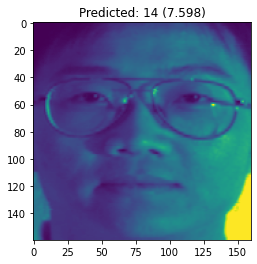

Predicted: 14 (7.598)
Expected: 2


In [46]:
# Show the image
plt.imshow(X_train[selection])
title = 'Predicted: %s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % rdm_name[0])

In [60]:
df.drop(columns=2,axis=0,inplace=True)

In [61]:
df

,subject,category,filename
0,1,gif,subject01.gif
1,1,glasses,subject01.glasses
2,1,glasses,subject01.glasses.gif
3,1,happy,subject01.happy
4,1,leftlight,subject01.leftlight
...,...,...,...
161,15,rightlight,subject15.rightlight
162,15,sad,subject15.sad
163,15,sleepy,subject15.sleepy
164,15,surprised,subject15.surprised


In [62]:
categorical_features = ['category','filename']

In [63]:
for col in categorical_features:
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)
    df.drop(col, axis=1, inplace=True)
df.head()

,subject,category_centerlight,category_gif,category_glasses,category_happy,category_leftlight,category_noglasses,category_normal,category_rightlight,category_sad,...,filename_subject15.glasses,filename_subject15.happy,filename_subject15.leftlight,filename_subject15.noglasses,filename_subject15.normal,filename_subject15.rightlight,filename_subject15.sad,filename_subject15.sleepy,filename_subject15.surprised,filename_subject15.wink
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Window

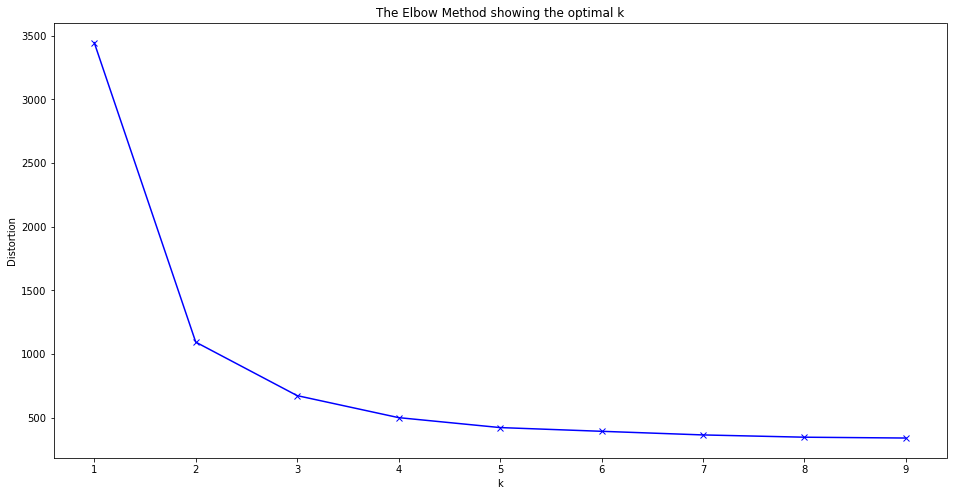

In [65]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [66]:
from sklearn.neighbors import KNeighborsClassifier
kmodel = KNeighborsClassifier(n_neighbors=3)

In [67]:
X_test_k = load_dataset(X_test_info)
X_train_k = load_dataset(X_train_info)

  0%|                                                                                           | 0/46 [00:00<?, ?it/s]

yalefaces/subject12.leftlight
1/1 [==============================] - 0s 50ms/step


  2%|█▊                                                                                 | 1/46 [00:01<00:52,  1.17s/it]

yalefaces/subject03.wink
1/1 [==============================] - 0s 56ms/step


  4%|███▌                                                                               | 2/46 [00:02<00:51,  1.17s/it]

yalefaces/subject11.wink
1/1 [==============================] - 0s 52ms/step


  7%|█████▍                                                                             | 3/46 [00:03<00:50,  1.17s/it]

yalefaces/subject12.happy
1/1 [==============================] - 0s 47ms/step


  9%|███████▏                                                                           | 4/46 [00:05<00:56,  1.34s/it]

yalefaces/subject02.rightlight
1/1 [==============================] - 0s 41ms/step


 11%|█████████                                                                          | 5/46 [00:06<00:52,  1.27s/it]

yalefaces/subject04.sad
1/1 [==============================] - 0s 52ms/step


 13%|██████████▊                                                                        | 6/46 [00:07<00:49,  1.24s/it]

yalefaces/subject15.sad
1/1 [==============================] - 0s 59ms/step


 15%|████████████▋                                                                      | 7/46 [00:08<00:47,  1.22s/it]

yalefaces/subject11.leftlight
1/1 [==============================] - 0s 33ms/step


 17%|██████████████▍                                                                    | 8/46 [00:09<00:45,  1.20s/it]

yalefaces/subject04.surprised
1/1 [==============================] - 0s 51ms/step


 20%|████████████████▏                                                                  | 9/46 [00:10<00:44,  1.19s/it]

yalefaces/subject14.happy
1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▊                                                                | 10/46 [00:12<00:42,  1.17s/it]

yalefaces/subject10.leftlight
1/1 [==============================] - 0s 58ms/step


 24%|███████████████████▌                                                              | 11/46 [00:13<00:40,  1.17s/it]

yalefaces/subject02.noglasses
1/1 [==============================] - 0s 52ms/step


 26%|█████████████████████▍                                                            | 12/46 [00:14<00:39,  1.16s/it]

yalefaces/subject13.surprised
1/1 [==============================] - 0s 41ms/step


 28%|███████████████████████▏                                                          | 13/46 [00:15<00:38,  1.16s/it]

yalefaces/subject03.rightlight
1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████▉                                                         | 14/46 [00:16<00:36,  1.13s/it]

yalefaces/subject03.centerlight
1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▋                                                       | 15/46 [00:17<00:33,  1.08s/it]

yalefaces/subject06.sad
1/1 [==============================] - 0s 54ms/step


 35%|████████████████████████████▌                                                     | 16/46 [00:18<00:32,  1.07s/it]

yalefaces/subject01.noglasses
1/1 [==============================] - 0s 43ms/step


 37%|██████████████████████████████▎                                                   | 17/46 [00:19<00:30,  1.07s/it]

yalefaces/subject08.sad
1/1 [==============================] - 0s 44ms/step


 39%|████████████████████████████████                                                  | 18/46 [00:20<00:29,  1.07s/it]

yalefaces/subject05.surprised
1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▊                                                | 19/46 [00:21<00:28,  1.06s/it]

yalefaces/subject09.happy
1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▋                                              | 20/46 [00:22<00:27,  1.06s/it]

yalefaces/subject14.glasses
1/1 [==============================] - 0s 51ms/step


 46%|█████████████████████████████████████▍                                            | 21/46 [00:23<00:26,  1.08s/it]

yalefaces/subject14.noglasses
1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 22/46 [00:25<00:25,  1.08s/it]

yalefaces/subject07.leftlight
1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 23/46 [00:26<00:24,  1.07s/it]

yalefaces/subject13.glasses
1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 24/46 [00:27<00:23,  1.08s/it]

yalefaces/subject05.centerlight
1/1 [==============================] - 0s 43ms/step


 54%|████████████████████████████████████████████▌                                     | 25/46 [00:28<00:22,  1.07s/it]

yalefaces/subject01.wink
1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▎                                   | 26/46 [00:29<00:21,  1.07s/it]

yalefaces/subject02.glasses
1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████▏                                 | 27/46 [00:30<00:20,  1.07s/it]

yalefaces/subject07.happy
1/1 [==============================] - 0s 49ms/step


 61%|█████████████████████████████████████████████████▉                                | 28/46 [00:31<00:19,  1.08s/it]

yalefaces/subject09.sad
1/1 [==============================] - 0s 47ms/step


 63%|███████████████████████████████████████████████████▋                              | 29/46 [00:32<00:19,  1.13s/it]

yalefaces/subject15.rightlight
1/1 [==============================] - 0s 51ms/step


 65%|█████████████████████████████████████████████████████▍                            | 30/46 [00:33<00:18,  1.15s/it]

yalefaces/subject08.wink
1/1 [==============================] - 0s 44ms/step


 67%|███████████████████████████████████████████████████████▎                          | 31/46 [00:35<00:17,  1.14s/it]

yalefaces/subject07.surprised
1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████                         | 32/46 [00:36<00:16,  1.15s/it]

yalefaces/subject12.surprised
1/1 [==============================] - 0s 40ms/step


 72%|██████████████████████████████████████████████████████████▊                       | 33/46 [00:37<00:14,  1.15s/it]

yalefaces/subject01.glasses.gif
1/1 [==============================] - 0s 51ms/step


 74%|████████████████████████████████████████████████████████████▌                     | 34/46 [00:38<00:13,  1.16s/it]

yalefaces/subject09.rightlight
1/1 [==============================] - 0s 41ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 35/46 [00:39<00:12,  1.16s/it]

yalefaces/subject06.sleepy
1/1 [==============================] - 0s 52ms/step


 78%|████████████████████████████████████████████████████████████████▏                 | 36/46 [00:40<00:11,  1.16s/it]

yalefaces/subject15.leftlight
1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▉                | 37/46 [00:42<00:10,  1.16s/it]

yalefaces/subject10.centerlight
1/1 [==============================] - 0s 50ms/step


 83%|███████████████████████████████████████████████████████████████████▋              | 38/46 [00:43<00:09,  1.17s/it]

yalefaces/subject11.sad
1/1 [==============================] - 0s 51ms/step


 85%|█████████████████████████████████████████████████████████████████████▌            | 39/46 [00:44<00:08,  1.19s/it]

yalefaces/subject06.normal
1/1 [==============================] - 0s 49ms/step


 87%|███████████████████████████████████████████████████████████████████████▎          | 40/46 [00:45<00:07,  1.19s/it]

yalefaces/subject13.sad
1/1 [==============================] - 0s 64ms/step


 89%|█████████████████████████████████████████████████████████████████████████         | 41/46 [00:46<00:05,  1.19s/it]

yalefaces/subject10.rightlight
1/1 [==============================] - 0s 53ms/step


 91%|██████████████████████████████████████████████████████████████████████████▊       | 42/46 [00:48<00:04,  1.19s/it]

yalefaces/subject05.rightlight
1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▋     | 43/46 [00:49<00:03,  1.18s/it]

yalefaces/subject01.sad
1/1 [==============================] - 0s 64ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 44/46 [00:50<00:02,  1.18s/it]

yalefaces/subject04.centerlight
1/1 [==============================] - 0s 64ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 45/46 [00:51<00:01,  1.18s/it]

yalefaces/subject08.happy
1/1 [==============================] - 0s 52ms/step


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

yalefaces/subject12.noglasses
1/1 [==============================] - 0s 49ms/step


  1%|▋                                                                                 | 1/120 [00:01<02:16,  1.15s/it]

yalefaces/subject15.glasses
1/1 [==============================] - 0s 49ms/step


  2%|█▎                                                                                | 2/120 [00:02<02:16,  1.16s/it]

yalefaces/subject10.surprised
1/1 [==============================] - 0s 54ms/step


  2%|██                                                                                | 3/120 [00:03<02:18,  1.18s/it]

yalefaces/subject13.leftlight
1/1 [==============================] - 0s 44ms/step


  3%|██▋                                                                               | 4/120 [00:04<02:18,  1.19s/it]

yalefaces/subject14.rightlight
1/1 [==============================] - 0s 47ms/step


  4%|███▍                                                                              | 5/120 [00:05<02:17,  1.20s/it]

yalefaces/subject10.glasses
1/1 [==============================] - 0s 63ms/step


  5%|████                                                                              | 6/120 [00:07<02:17,  1.21s/it]

yalefaces/subject01.leftlight
1/1 [==============================] - 0s 48ms/step


  6%|████▊                                                                             | 7/120 [00:08<02:16,  1.21s/it]

yalefaces/subject09.leftlight
1/1 [==============================] - 0s 51ms/step


  7%|█████▍                                                                            | 8/120 [00:09<02:15,  1.21s/it]

yalefaces/subject12.sad
1/1 [==============================] - 0s 60ms/step


  8%|██████▏                                                                           | 9/120 [00:10<02:15,  1.22s/it]

yalefaces/subject15.centerlight
1/1 [==============================] - 0s 54ms/step


  8%|██████▊                                                                          | 10/120 [00:12<02:14,  1.22s/it]

yalefaces/subject06.centerlight
1/1 [==============================] - 0s 48ms/step


  9%|███████▍                                                                         | 11/120 [00:13<02:12,  1.21s/it]

yalefaces/subject02.centerlight
1/1 [==============================] - 0s 48ms/step


 10%|████████                                                                         | 12/120 [00:14<02:10,  1.21s/it]

yalefaces/subject10.sad
1/1 [==============================] - 0s 55ms/step


 11%|████████▊                                                                        | 13/120 [00:15<02:08,  1.20s/it]

yalefaces/subject12.glasses
1/1 [==============================] - 0s 44ms/step


 12%|█████████▍                                                                       | 14/120 [00:16<02:05,  1.18s/it]

yalefaces/subject12.sleepy
1/1 [==============================] - 0s 53ms/step


 12%|██████████▏                                                                      | 15/120 [00:17<02:03,  1.17s/it]

yalefaces/subject09.surprised
1/1 [==============================] - 0s 54ms/step


 13%|██████████▊                                                                      | 16/120 [00:19<02:01,  1.17s/it]

yalefaces/subject09.noglasses
1/1 [==============================] - 0s 57ms/step


 14%|███████████▍                                                                     | 17/120 [00:20<02:01,  1.18s/it]

yalefaces/subject01.surprised
1/1 [==============================] - 0s 50ms/step


 15%|████████████▏                                                                    | 18/120 [00:21<01:59,  1.17s/it]

yalefaces/subject05.sad
1/1 [==============================] - 0s 52ms/step


 16%|████████████▊                                                                    | 19/120 [00:22<01:57,  1.17s/it]

yalefaces/subject06.leftlight
1/1 [==============================] - 0s 44ms/step


 17%|█████████████▌                                                                   | 20/120 [00:23<01:55,  1.16s/it]

yalefaces/subject03.normal
1/1 [==============================] - 0s 53ms/step


 18%|██████████████▏                                                                  | 21/120 [00:24<01:55,  1.17s/it]

yalefaces/subject11.happy
1/1 [==============================] - 0s 52ms/step


 18%|██████████████▊                                                                  | 22/120 [00:26<01:54,  1.17s/it]

yalefaces/subject11.rightlight
1/1 [==============================] - 0s 56ms/step


 19%|███████████████▌                                                                 | 23/120 [00:27<01:53,  1.17s/it]

yalefaces/subject03.surprised
1/1 [==============================] - 0s 63ms/step


 20%|████████████████▏                                                                | 24/120 [00:28<01:53,  1.18s/it]

yalefaces/subject04.happy
1/1 [==============================] - 0s 53ms/step


 21%|████████████████▉                                                                | 25/120 [00:29<01:52,  1.18s/it]

yalefaces/subject05.glasses
1/1 [==============================] - 0s 48ms/step


 22%|█████████████████▌                                                               | 26/120 [00:30<01:50,  1.18s/it]

yalefaces/subject07.rightlight
1/1 [==============================] - 0s 53ms/step


 22%|██████████████████▏                                                              | 27/120 [00:32<01:49,  1.18s/it]

yalefaces/subject12.centerlight
1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▉                                                              | 28/120 [00:33<01:48,  1.18s/it]

yalefaces/subject14.surprised
1/1 [==============================] - 0s 40ms/step


 24%|███████████████████▌                                                             | 29/120 [00:34<01:47,  1.19s/it]

yalefaces/subject01.gif
1/1 [==============================] - 0s 46ms/step


 25%|████████████████████▎                                                            | 30/120 [00:35<01:45,  1.18s/it]

yalefaces/subject15.normal
1/1 [==============================] - 0s 50ms/step


 26%|████████████████████▉                                                            | 31/120 [00:36<01:45,  1.19s/it]

yalefaces/subject10.wink
1/1 [==============================] - 0s 58ms/step


 27%|█████████████████████▌                                                           | 32/120 [00:38<01:48,  1.24s/it]

yalefaces/subject03.sad
1/1 [==============================] - 0s 56ms/step


 28%|██████████████████████▎                                                          | 33/120 [00:39<01:51,  1.28s/it]

yalefaces/subject04.sleepy
1/1 [==============================] - 0s 48ms/step


 28%|██████████████████████▉                                                          | 34/120 [00:40<01:48,  1.26s/it]

yalefaces/subject02.normal
1/1 [==============================] - 0s 45ms/step


 29%|███████████████████████▋                                                         | 35/120 [00:41<01:44,  1.23s/it]

yalefaces/subject01.rightlight
1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▎                                                        | 36/120 [00:43<01:42,  1.22s/it]

yalefaces/subject11.glasses
1/1 [==============================] - 0s 59ms/step


 31%|████████████████████████▉                                                        | 37/120 [00:44<01:40,  1.21s/it]

yalefaces/subject02.sleepy
1/1 [==============================] - 0s 49ms/step


 32%|█████████████████████████▋                                                       | 38/120 [00:45<01:38,  1.20s/it]

yalefaces/subject11.sleepy
1/1 [==============================] - 0s 57ms/step


 32%|██████████████████████████▎                                                      | 39/120 [00:46<01:38,  1.21s/it]

yalefaces/subject14.normal
1/1 [==============================] - 0s 54ms/step


 33%|███████████████████████████                                                      | 40/120 [00:47<01:38,  1.23s/it]

yalefaces/subject13.sleepy
1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▋                                                     | 41/120 [00:49<01:35,  1.21s/it]

yalefaces/subject06.surprised
1/1 [==============================] - 0s 56ms/step


 35%|████████████████████████████▎                                                    | 42/120 [00:50<01:33,  1.20s/it]

yalefaces/subject04.glasses
1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████                                                    | 43/120 [00:51<01:31,  1.19s/it]

yalefaces/subject03.glasses
1/1 [==============================] - 0s 51ms/step


 37%|█████████████████████████████▋                                                   | 44/120 [00:52<01:29,  1.18s/it]

yalefaces/subject06.wink
1/1 [==============================] - 0s 48ms/step


 38%|██████████████████████████████▍                                                  | 45/120 [00:53<01:28,  1.18s/it]

yalefaces/subject04.wink
1/1 [==============================] - 0s 63ms/step


 38%|███████████████████████████████                                                  | 46/120 [00:54<01:26,  1.17s/it]

yalefaces/subject11.surprised
1/1 [==============================] - 0s 56ms/step


 39%|███████████████████████████████▋                                                 | 47/120 [00:56<01:25,  1.17s/it]

yalefaces/subject02.sad
1/1 [==============================] - 0s 48ms/step


 40%|████████████████████████████████▍                                                | 48/120 [00:57<01:24,  1.17s/it]

yalefaces/subject03.leftlight
1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████                                                | 49/120 [00:58<01:22,  1.17s/it]

yalefaces/subject02.happy
1/1 [==============================] - 0s 48ms/step


 42%|█████████████████████████████████▊                                               | 50/120 [00:59<01:21,  1.17s/it]

yalefaces/subject01.normal
1/1 [==============================] - 0s 49ms/step


 42%|██████████████████████████████████▍                                              | 51/120 [01:00<01:20,  1.16s/it]

yalefaces/subject14.sleepy
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████                                              | 52/120 [01:01<01:18,  1.16s/it]

yalefaces/subject01.sleepy
1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████▊                                             | 53/120 [01:02<01:16,  1.14s/it]

yalefaces/subject06.glasses
1/1 [==============================] - 0s 40ms/step


 45%|████████████████████████████████████▍                                            | 54/120 [01:04<01:14,  1.14s/it]

yalefaces/subject08.sleepy
1/1 [==============================] - 0s 49ms/step


 46%|█████████████████████████████████████▏                                           | 55/120 [01:05<01:14,  1.14s/it]

yalefaces/subject07.normal
1/1 [==============================] - 0s 51ms/step


 47%|█████████████████████████████████████▊                                           | 56/120 [01:06<01:13,  1.14s/it]

yalefaces/subject05.noglasses
1/1 [==============================] - 0s 53ms/step


 48%|██████████████████████████████████████▍                                          | 57/120 [01:07<01:12,  1.15s/it]

yalefaces/subject07.wink
1/1 [==============================] - 0s 51ms/step


 48%|███████████████████████████████████████▏                                         | 58/120 [01:08<01:11,  1.16s/it]

yalefaces/subject10.noglasses
1/1 [==============================] - 0s 53ms/step


 49%|███████████████████████████████████████▊                                         | 59/120 [01:09<01:11,  1.17s/it]

yalefaces/subject07.centerlight
1/1 [==============================] - 0s 52ms/step


 50%|████████████████████████████████████████▌                                        | 60/120 [01:11<01:10,  1.17s/it]

yalefaces/subject08.glasses
1/1 [==============================] - 0s 49ms/step


 51%|█████████████████████████████████████████▏                                       | 61/120 [01:12<01:08,  1.17s/it]

yalefaces/subject13.noglasses
1/1 [==============================] - 0s 50ms/step


 52%|█████████████████████████████████████████▊                                       | 62/120 [01:13<01:07,  1.17s/it]

yalefaces/subject03.happy
1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▌                                      | 63/120 [01:14<01:06,  1.17s/it]

yalefaces/subject12.wink
1/1 [==============================] - 0s 52ms/step


 53%|███████████████████████████████████████████▏                                     | 64/120 [01:15<01:05,  1.16s/it]

yalefaces/subject15.wink
1/1 [==============================] - 0s 57ms/step


 54%|███████████████████████████████████████████▉                                     | 65/120 [01:16<01:04,  1.16s/it]

yalefaces/subject06.happy
1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▌                                    | 66/120 [01:18<01:02,  1.16s/it]

yalefaces/subject12.rightlight
1/1 [==============================] - 0s 49ms/step


 56%|█████████████████████████████████████████████▏                                   | 67/120 [01:19<01:01,  1.16s/it]

yalefaces/subject07.glasses
1/1 [==============================] - 0s 42ms/step


 57%|█████████████████████████████████████████████▉                                   | 68/120 [01:20<01:00,  1.16s/it]

yalefaces/subject09.sleepy
1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                  | 69/120 [01:21<00:59,  1.16s/it]

yalefaces/subject14.sad
1/1 [==============================] - 0s 53ms/step


 58%|███████████████████████████████████████████████▎                                 | 70/120 [01:22<00:58,  1.16s/it]

yalefaces/subject15.surprised
1/1 [==============================] - 0s 40ms/step


 59%|███████████████████████████████████████████████▉                                 | 71/120 [01:23<00:57,  1.17s/it]

yalefaces/subject03.noglasses
1/1 [==============================] - 0s 53ms/step


 60%|████████████████████████████████████████████████▌                                | 72/120 [01:25<00:57,  1.19s/it]

yalefaces/subject08.centerlight
1/1 [==============================] - 0s 57ms/step


 61%|█████████████████████████████████████████████████▎                               | 73/120 [01:26<00:55,  1.19s/it]

yalefaces/subject04.normal
1/1 [==============================] - 0s 57ms/step


 62%|█████████████████████████████████████████████████▉                               | 74/120 [01:27<00:54,  1.18s/it]

yalefaces/subject05.leftlight
1/1 [==============================] - 0s 40ms/step


 62%|██████████████████████████████████████████████████▋                              | 75/120 [01:28<00:52,  1.17s/it]

yalefaces/subject08.leftlight
1/1 [==============================] - 0s 48ms/step


 63%|███████████████████████████████████████████████████▎                             | 76/120 [01:29<00:51,  1.16s/it]

yalefaces/subject13.happy
1/1 [==============================] - 0s 38ms/step


 64%|███████████████████████████████████████████████████▉                             | 77/120 [01:30<00:50,  1.16s/it]

yalefaces/subject07.sad
1/1 [==============================] - 0s 60ms/step


 65%|████████████████████████████████████████████████████▋                            | 78/120 [01:32<00:49,  1.18s/it]

yalefaces/subject10.happy
1/1 [==============================] - 0s 56ms/step


 66%|█████████████████████████████████████████████████████▎                           | 79/120 [01:33<00:48,  1.19s/it]

yalefaces/subject15.sleepy
1/1 [==============================] - 0s 57ms/step


 67%|██████████████████████████████████████████████████████                           | 80/120 [01:34<00:47,  1.19s/it]

yalefaces/subject01.happy
1/1 [==============================] - 0s 48ms/step


 68%|██████████████████████████████████████████████████████▋                          | 81/120 [01:35<00:45,  1.18s/it]

yalefaces/subject10.sleepy
1/1 [==============================] - 0s 56ms/step


 68%|███████████████████████████████████████████████████████▎                         | 82/120 [01:36<00:44,  1.17s/it]

yalefaces/subject11.normal
1/1 [==============================] - 0s 56ms/step


 69%|████████████████████████████████████████████████████████                         | 83/120 [01:38<00:43,  1.17s/it]

yalefaces/subject11.centerlight
1/1 [==============================] - 0s 49ms/step


 70%|████████████████████████████████████████████████████████▋                        | 84/120 [01:39<00:41,  1.16s/it]

yalefaces/subject14.wink
1/1 [==============================] - 0s 48ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 85/120 [01:40<00:40,  1.17s/it]

yalefaces/subject08.rightlight
1/1 [==============================] - 0s 52ms/step


 72%|██████████████████████████████████████████████████████████                       | 86/120 [01:42<00:45,  1.34s/it]

yalefaces/subject13.normal
1/1 [==============================] - 0s 46ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 87/120 [01:43<00:42,  1.30s/it]

yalefaces/subject07.sleepy
1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▍                     | 88/120 [01:44<00:40,  1.26s/it]

yalefaces/subject02.surprised
1/1 [==============================] - 0s 41ms/step


 74%|████████████████████████████████████████████████████████████                     | 89/120 [01:45<00:38,  1.23s/it]

yalefaces/subject10.normal
1/1 [==============================] - 0s 57ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 90/120 [01:46<00:36,  1.21s/it]

yalefaces/subject13.rightlight
1/1 [==============================] - 0s 49ms/step


 76%|█████████████████████████████████████████████████████████████▍                   | 91/120 [01:47<00:34,  1.20s/it]

yalefaces/subject13.centerlight
1/1 [==============================] - 0s 44ms/step


 77%|██████████████████████████████████████████████████████████████                   | 92/120 [01:49<00:33,  1.19s/it]

yalefaces/subject03.sleepy
1/1 [==============================] - 0s 56ms/step


 78%|██████████████████████████████████████████████████████████████▊                  | 93/120 [01:50<00:31,  1.18s/it]

yalefaces/subject07.noglasses
1/1 [==============================] - 0s 54ms/step


 78%|███████████████████████████████████████████████████████████████▍                 | 94/120 [01:51<00:30,  1.18s/it]

yalefaces/subject09.centerlight
1/1 [==============================] - 0s 52ms/step


 79%|████████████████████████████████████████████████████████████████▏                | 95/120 [01:52<00:29,  1.19s/it]

yalefaces/subject04.noglasses
1/1 [==============================] - 0s 47ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 96/120 [01:53<00:28,  1.17s/it]

yalefaces/subject02.wink
1/1 [==============================] - 0s 50ms/step


 81%|█████████████████████████████████████████████████████████████████▍               | 97/120 [01:54<00:27,  1.18s/it]

yalefaces/subject06.noglasses
1/1 [==============================] - 0s 56ms/step


 82%|██████████████████████████████████████████████████████████████████▏              | 98/120 [01:56<00:25,  1.18s/it]

yalefaces/subject15.noglasses
1/1 [==============================] - 0s 42ms/step


 82%|██████████████████████████████████████████████████████████████████▊              | 99/120 [01:57<00:24,  1.17s/it]

yalefaces/subject13.wink
1/1 [==============================] - 0s 48ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 100/120 [01:58<00:23,  1.17s/it]

yalefaces/subject09.glasses
1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 101/120 [01:59<00:22,  1.16s/it]

yalefaces/subject14.centerlight
1/1 [==============================] - 0s 56ms/step


 85%|████████████████████████████████████████████████████████████████████            | 102/120 [02:00<00:21,  1.17s/it]

yalefaces/subject15.happy
1/1 [==============================] - 0s 50ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 103/120 [02:02<00:19,  1.17s/it]

yalefaces/subject05.sleepy
1/1 [==============================] - 0s 48ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 104/120 [02:03<00:18,  1.18s/it]

yalefaces/subject05.normal
1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 105/120 [02:04<00:17,  1.17s/it]

yalefaces/subject08.noglasses
1/1 [==============================] - 0s 49ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 106/120 [02:05<00:16,  1.17s/it]

yalefaces/subject09.normal
1/1 [==============================] - 0s 40ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 107/120 [02:06<00:15,  1.17s/it]

yalefaces/subject12.normal
1/1 [==============================] - 0s 56ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 108/120 [02:07<00:14,  1.17s/it]

yalefaces/subject01.glasses
1/1 [==============================] - 0s 49ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 109/120 [02:09<00:12,  1.16s/it]

yalefaces/subject06.rightlight
1/1 [==============================] - 0s 49ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 110/120 [02:10<00:11,  1.18s/it]

yalefaces/subject05.wink
1/1 [==============================] - 0s 42ms/step


 92%|██████████████████████████████████████████████████████████████████████████      | 111/120 [02:11<00:10,  1.17s/it]

yalefaces/subject02.leftlight
1/1 [==============================] - 0s 46ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 112/120 [02:12<00:09,  1.16s/it]

yalefaces/subject05.happy
1/1 [==============================] - 0s 50ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 113/120 [02:13<00:08,  1.20s/it]

yalefaces/subject11.noglasses
1/1 [==============================] - 0s 57ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 114/120 [02:15<00:07,  1.20s/it]

yalefaces/subject04.leftlight
1/1 [==============================] - 0s 49ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 115/120 [02:16<00:05,  1.19s/it]

yalefaces/subject08.normal
1/1 [==============================] - 0s 41ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 116/120 [02:17<00:04,  1.21s/it]

yalefaces/subject09.wink
1/1 [==============================] - 0s 49ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 117/120 [02:18<00:03,  1.20s/it]

yalefaces/subject04.rightlight
1/1 [==============================] - 0s 50ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 118/120 [02:19<00:02,  1.19s/it]

yalefaces/subject14.leftlight
1/1 [==============================] - 0s 50ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 119/120 [02:20<00:01,  1.19s/it]

yalefaces/subject08.surprised
1/1 [==============================] - 0s 56ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [02:22<00:00,  1.18s/it]


In [68]:
# Normalize vector inputs
in_encoder = Normalizer(norm='l2')

X_train_reshaped_k = X_train_k.reshape(X_train_k.shape[0],X_train_k.shape[1]*X_train_k.shape[2])
print('Reshaped X_train', X_train_reshaped_k.shape)
X_train_reshaped_k = in_encoder.transform(X_train_reshaped_k)

X_test_reshaped_k = X_test_k.reshape(X_test_k.shape[0],X_test_k.shape[1]*X_test_k.shape[2])
print('Reshaped X_test', X_test_reshaped_k.shape)
X_test_reshaped_k = in_encoder.transform(X_test_reshaped_k)

# Encode targets with labels
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

Reshaped X_train (120, 25600)
Reshaped X_test (46, 25600)


LabelEncoder()

In [69]:
kmodel.fit(X_train_reshaped_k, y_train)


KNeighborsClassifier(n_neighbors=3)

In [70]:
k_train = kmodel.predict(X_train_reshaped_k)
k_test = kmodel.predict(X_test_reshaped_k)

kscore_train = accuracy_score(y_train, k_train)
kscore_test = accuracy_score(y_test, k_test)
# Summarize
print('Accuracy: train=%.3f, test=%.3f' % (kscore_train*100, kscore_test*100))

Accuracy: train=86.667, test=69.565


In [71]:
knn_predictions = kmodel.predict(X_test_reshaped_k)
print(classification_report(y_test,knn_predictions))

              precision    recall  f1-score   support

           1       0.36      1.00      0.53         4
           2       1.00      0.67      0.80         3
           3       0.50      0.67      0.57         3
           4       1.00      1.00      1.00         3
           5       1.00      0.33      0.50         3
           6       0.38      1.00      0.55         3
           7       1.00      0.67      0.80         3
           8       1.00      0.67      0.80         3
           9       1.00      0.67      0.80         3
          10       0.00      0.00      0.00         3
          11       1.00      0.67      0.80         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      0.33      0.50         3

    accuracy                           0.70        46
   macro avg       0.82      0.69      0.70        46
weighted avg       0.81   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
#execute for random image
selection = random.randint(1, 34)
rdm_emb = X_test_reshaped[selection]
rdm_class = y_test[selection]
rdm_name = out_encoder.inverse_transform([rdm_class]) - 1

# forecast 
samples = np.expand_dims(rdm_emb, axis=0)
y_class = model.predict(samples)
y_prob = model.predict_proba(samples)

class_index = y_class[0]
class_probability = y_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(y_class) - 1

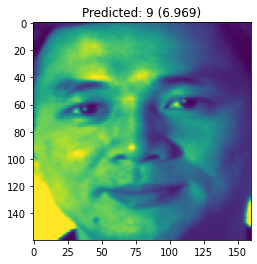

Predicted: 9 (6.969)
Expected: 9


In [90]:
# Show the image
plt.imshow(X_train[selection])
title = 'Predicted: %s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % rdm_name[0])

In [74]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)

In [75]:
X_test_rf = load_dataset(X_test_info)
X_train_rf = load_dataset(X_train_info)

  0%|                                                                                           | 0/46 [00:00<?, ?it/s]

yalefaces/subject12.leftlight
1/1 [==============================] - 0s 42ms/step


  2%|█▊                                                                                 | 1/46 [00:01<00:56,  1.26s/it]

yalefaces/subject03.wink
1/1 [==============================] - 0s 56ms/step


  4%|███▌                                                                               | 2/46 [00:02<00:56,  1.28s/it]

yalefaces/subject11.wink
1/1 [==============================] - 0s 58ms/step


  7%|█████▍                                                                             | 3/46 [00:03<00:53,  1.25s/it]

yalefaces/subject12.happy
1/1 [==============================] - 0s 49ms/step


  9%|███████▏                                                                           | 4/46 [00:04<00:51,  1.23s/it]

yalefaces/subject02.rightlight
1/1 [==============================] - 0s 46ms/step


 11%|█████████                                                                          | 5/46 [00:06<00:49,  1.21s/it]

yalefaces/subject04.sad
1/1 [==============================] - 0s 44ms/step


 13%|██████████▊                                                                        | 6/46 [00:07<00:48,  1.21s/it]

yalefaces/subject15.sad
1/1 [==============================] - 0s 56ms/step


 15%|████████████▋                                                                      | 7/46 [00:08<00:46,  1.20s/it]

yalefaces/subject11.leftlight
1/1 [==============================] - 0s 43ms/step


 17%|██████████████▍                                                                    | 8/46 [00:09<00:44,  1.18s/it]

yalefaces/subject04.surprised
1/1 [==============================] - 0s 55ms/step


 20%|████████████████▏                                                                  | 9/46 [00:10<00:43,  1.18s/it]

yalefaces/subject14.happy
1/1 [==============================] - 0s 53ms/step


 22%|█████████████████▊                                                                | 10/46 [00:12<00:42,  1.17s/it]

yalefaces/subject10.leftlight
1/1 [==============================] - 0s 46ms/step


 24%|███████████████████▌                                                              | 11/46 [00:13<00:41,  1.18s/it]

yalefaces/subject02.noglasses
1/1 [==============================] - 0s 41ms/step


 26%|█████████████████████▍                                                            | 12/46 [00:14<00:40,  1.18s/it]

yalefaces/subject13.surprised
1/1 [==============================] - 0s 55ms/step


 28%|███████████████████████▏                                                          | 13/46 [00:15<00:38,  1.17s/it]

yalefaces/subject03.rightlight
1/1 [==============================] - 0s 60ms/step


 30%|████████████████████████▉                                                         | 14/46 [00:16<00:37,  1.17s/it]

yalefaces/subject03.centerlight
1/1 [==============================] - 0s 55ms/step


 33%|██████████████████████████▋                                                       | 15/46 [00:17<00:36,  1.17s/it]

yalefaces/subject06.sad
1/1 [==============================] - 0s 53ms/step


 35%|████████████████████████████▌                                                     | 16/46 [00:19<00:35,  1.17s/it]

yalefaces/subject01.noglasses
1/1 [==============================] - 0s 50ms/step


 37%|██████████████████████████████▎                                                   | 17/46 [00:20<00:33,  1.17s/it]

yalefaces/subject08.sad
1/1 [==============================] - 0s 58ms/step


 39%|████████████████████████████████                                                  | 18/46 [00:21<00:32,  1.18s/it]

yalefaces/subject05.surprised
1/1 [==============================] - 0s 58ms/step


 41%|█████████████████████████████████▊                                                | 19/46 [00:22<00:31,  1.17s/it]

yalefaces/subject09.happy
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▋                                              | 20/46 [00:23<00:30,  1.17s/it]

yalefaces/subject14.glasses
1/1 [==============================] - 0s 48ms/step


 46%|█████████████████████████████████████▍                                            | 21/46 [00:24<00:29,  1.16s/it]

yalefaces/subject14.noglasses
1/1 [==============================] - 0s 60ms/step


 48%|███████████████████████████████████████▏                                          | 22/46 [00:26<00:28,  1.17s/it]

yalefaces/subject07.leftlight
1/1 [==============================] - 0s 54ms/step


 50%|█████████████████████████████████████████                                         | 23/46 [00:27<00:26,  1.17s/it]

yalefaces/subject13.glasses
1/1 [==============================] - 0s 59ms/step


 52%|██████████████████████████████████████████▊                                       | 24/46 [00:28<00:25,  1.17s/it]

yalefaces/subject05.centerlight
1/1 [==============================] - 0s 57ms/step


 54%|████████████████████████████████████████████▌                                     | 25/46 [00:29<00:24,  1.17s/it]

yalefaces/subject01.wink
1/1 [==============================] - 0s 84ms/step


 57%|██████████████████████████████████████████████▎                                   | 26/46 [00:30<00:23,  1.19s/it]

yalefaces/subject02.glasses
1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▏                                 | 27/46 [00:31<00:22,  1.19s/it]

yalefaces/subject07.happy
1/1 [==============================] - 0s 54ms/step


 61%|█████████████████████████████████████████████████▉                                | 28/46 [00:33<00:21,  1.18s/it]

yalefaces/subject09.sad
1/1 [==============================] - 0s 57ms/step


 63%|███████████████████████████████████████████████████▋                              | 29/46 [00:34<00:20,  1.18s/it]

yalefaces/subject15.rightlight
1/1 [==============================] - 0s 43ms/step


 65%|█████████████████████████████████████████████████████▍                            | 30/46 [00:35<00:18,  1.18s/it]

yalefaces/subject08.wink
1/1 [==============================] - 0s 42ms/step


 67%|███████████████████████████████████████████████████████▎                          | 31/46 [00:36<00:17,  1.19s/it]

yalefaces/subject07.surprised
1/1 [==============================] - 0s 65ms/step


 70%|█████████████████████████████████████████████████████████                         | 32/46 [00:37<00:16,  1.18s/it]

yalefaces/subject12.surprised
1/1 [==============================] - 0s 53ms/step


 72%|██████████████████████████████████████████████████████████▊                       | 33/46 [00:39<00:15,  1.17s/it]

yalefaces/subject01.glasses.gif
1/1 [==============================] - 0s 49ms/step


 74%|████████████████████████████████████████████████████████████▌                     | 34/46 [00:40<00:14,  1.17s/it]

yalefaces/subject09.rightlight
1/1 [==============================] - 0s 61ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 35/46 [00:41<00:12,  1.18s/it]

yalefaces/subject06.sleepy
1/1 [==============================] - 0s 56ms/step


 78%|████████████████████████████████████████████████████████████████▏                 | 36/46 [00:42<00:11,  1.18s/it]

yalefaces/subject15.leftlight
1/1 [==============================] - 0s 52ms/step


 80%|█████████████████████████████████████████████████████████████████▉                | 37/46 [00:43<00:10,  1.17s/it]

yalefaces/subject10.centerlight
1/1 [==============================] - 0s 63ms/step


 83%|███████████████████████████████████████████████████████████████████▋              | 38/46 [00:44<00:09,  1.17s/it]

yalefaces/subject11.sad
1/1 [==============================] - 0s 46ms/step


 85%|█████████████████████████████████████████████████████████████████████▌            | 39/46 [00:46<00:08,  1.16s/it]

yalefaces/subject06.normal
1/1 [==============================] - 0s 47ms/step


 87%|███████████████████████████████████████████████████████████████████████▎          | 40/46 [00:47<00:07,  1.17s/it]

yalefaces/subject13.sad
1/1 [==============================] - 0s 48ms/step


 89%|█████████████████████████████████████████████████████████████████████████         | 41/46 [00:48<00:05,  1.17s/it]

yalefaces/subject10.rightlight
1/1 [==============================] - 0s 51ms/step


 91%|██████████████████████████████████████████████████████████████████████████▊       | 42/46 [00:49<00:04,  1.17s/it]

yalefaces/subject05.rightlight
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▋     | 43/46 [00:50<00:03,  1.16s/it]

yalefaces/subject01.sad
1/1 [==============================] - 0s 46ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 44/46 [00:51<00:02,  1.16s/it]

yalefaces/subject04.centerlight
1/1 [==============================] - 0s 65ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 45/46 [00:53<00:01,  1.17s/it]

yalefaces/subject08.happy
1/1 [==============================] - 0s 61ms/step


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

yalefaces/subject12.noglasses
1/1 [==============================] - 0s 53ms/step


  1%|▋                                                                                 | 1/120 [00:01<02:18,  1.17s/it]

yalefaces/subject15.glasses
1/1 [==============================] - 0s 42ms/step


  2%|█▎                                                                                | 2/120 [00:02<02:17,  1.16s/it]

yalefaces/subject10.surprised
1/1 [==============================] - 0s 49ms/step


  2%|██                                                                                | 3/120 [00:03<02:16,  1.17s/it]

yalefaces/subject13.leftlight
1/1 [==============================] - 0s 46ms/step


  3%|██▋                                                                               | 4/120 [00:04<02:17,  1.19s/it]

yalefaces/subject14.rightlight
1/1 [==============================] - 0s 42ms/step


  4%|███▍                                                                              | 5/120 [00:05<02:18,  1.21s/it]

yalefaces/subject10.glasses
1/1 [==============================] - 0s 57ms/step


  5%|████                                                                              | 6/120 [00:07<02:17,  1.20s/it]

yalefaces/subject01.leftlight
1/1 [==============================] - 0s 54ms/step


  6%|████▊                                                                             | 7/120 [00:08<02:14,  1.19s/it]

yalefaces/subject09.leftlight
1/1 [==============================] - 0s 46ms/step


  7%|█████▍                                                                            | 8/120 [00:09<02:12,  1.19s/it]

yalefaces/subject12.sad
1/1 [==============================] - 0s 50ms/step


  8%|██████▏                                                                           | 9/120 [00:10<02:11,  1.18s/it]

yalefaces/subject15.centerlight
1/1 [==============================] - 0s 58ms/step


  8%|██████▊                                                                          | 10/120 [00:11<02:10,  1.19s/it]

yalefaces/subject06.centerlight
1/1 [==============================] - 0s 49ms/step


  9%|███████▍                                                                         | 11/120 [00:13<02:08,  1.18s/it]

yalefaces/subject02.centerlight
1/1 [==============================] - 0s 41ms/step


 10%|████████                                                                         | 12/120 [00:14<02:06,  1.17s/it]

yalefaces/subject10.sad
1/1 [==============================] - 0s 68ms/step


 11%|████████▊                                                                        | 13/120 [00:15<02:06,  1.18s/it]

yalefaces/subject12.glasses
1/1 [==============================] - 0s 43ms/step


 12%|█████████▍                                                                       | 14/120 [00:16<02:05,  1.18s/it]

yalefaces/subject12.sleepy
1/1 [==============================] - 0s 47ms/step


 12%|██████████▏                                                                      | 15/120 [00:17<02:03,  1.17s/it]

yalefaces/subject09.surprised
1/1 [==============================] - 0s 48ms/step


 13%|██████████▊                                                                      | 16/120 [00:18<02:01,  1.17s/it]

yalefaces/subject09.noglasses
1/1 [==============================] - 0s 41ms/step


 14%|███████████▍                                                                     | 17/120 [00:20<02:00,  1.17s/it]

yalefaces/subject01.surprised
1/1 [==============================] - 0s 55ms/step


 15%|████████████▏                                                                    | 18/120 [00:21<01:58,  1.16s/it]

yalefaces/subject05.sad
1/1 [==============================] - 0s 52ms/step


 16%|████████████▊                                                                    | 19/120 [00:22<01:57,  1.16s/it]

yalefaces/subject06.leftlight
1/1 [==============================] - 0s 56ms/step


 17%|█████████████▌                                                                   | 20/120 [00:23<01:56,  1.16s/it]

yalefaces/subject03.normal
1/1 [==============================] - 0s 58ms/step


 18%|██████████████▏                                                                  | 21/120 [00:24<01:55,  1.16s/it]

yalefaces/subject11.happy
1/1 [==============================] - 0s 50ms/step


 18%|██████████████▊                                                                  | 22/120 [00:25<01:53,  1.16s/it]

yalefaces/subject11.rightlight
1/1 [==============================] - 0s 40ms/step


 19%|███████████████▌                                                                 | 23/120 [00:26<01:52,  1.16s/it]

yalefaces/subject03.surprised
1/1 [==============================] - 0s 56ms/step


 20%|████████████████▏                                                                | 24/120 [00:28<01:51,  1.16s/it]

yalefaces/subject04.happy
1/1 [==============================] - 0s 47ms/step


 21%|████████████████▉                                                                | 25/120 [00:29<01:49,  1.15s/it]

yalefaces/subject05.glasses
1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▌                                                               | 26/120 [00:30<01:48,  1.15s/it]

yalefaces/subject07.rightlight
1/1 [==============================] - 0s 55ms/step


 22%|██████████████████▏                                                              | 27/120 [00:31<01:46,  1.15s/it]

yalefaces/subject12.centerlight
1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▉                                                              | 28/120 [00:32<01:45,  1.15s/it]

yalefaces/subject14.surprised
1/1 [==============================] - 0s 49ms/step


 24%|███████████████████▌                                                             | 29/120 [00:33<01:44,  1.15s/it]

yalefaces/subject01.gif
1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▎                                                            | 30/120 [00:35<01:46,  1.18s/it]

yalefaces/subject15.normal
1/1 [==============================] - 0s 45ms/step


 26%|████████████████████▉                                                            | 31/120 [00:36<01:45,  1.19s/it]

yalefaces/subject10.wink
1/1 [==============================] - 0s 48ms/step


 27%|█████████████████████▌                                                           | 32/120 [00:37<01:43,  1.18s/it]

yalefaces/subject03.sad
1/1 [==============================] - 0s 56ms/step


 28%|██████████████████████▎                                                          | 33/120 [00:38<01:42,  1.17s/it]

yalefaces/subject04.sleepy
1/1 [==============================] - 0s 53ms/step


 28%|██████████████████████▉                                                          | 34/120 [00:39<01:41,  1.18s/it]

yalefaces/subject02.normal
1/1 [==============================] - 0s 46ms/step


 29%|███████████████████████▋                                                         | 35/120 [00:40<01:39,  1.17s/it]

yalefaces/subject01.rightlight
1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▎                                                        | 36/120 [00:42<01:38,  1.17s/it]

yalefaces/subject11.glasses
1/1 [==============================] - 0s 55ms/step


 31%|████████████████████████▉                                                        | 37/120 [00:43<01:37,  1.17s/it]

yalefaces/subject02.sleepy
1/1 [==============================] - 0s 53ms/step


 32%|█████████████████████████▋                                                       | 38/120 [00:44<01:36,  1.17s/it]

yalefaces/subject11.sleepy
1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████▎                                                      | 39/120 [00:45<01:35,  1.17s/it]

yalefaces/subject14.normal
1/1 [==============================] - 0s 47ms/step


 33%|███████████████████████████                                                      | 40/120 [00:46<01:33,  1.17s/it]

yalefaces/subject13.sleepy
1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▋                                                     | 41/120 [00:48<01:31,  1.16s/it]

yalefaces/subject06.surprised
1/1 [==============================] - 0s 51ms/step


 35%|████████████████████████████▎                                                    | 42/120 [00:49<01:31,  1.17s/it]

yalefaces/subject04.glasses
1/1 [==============================] - 0s 53ms/step


 36%|█████████████████████████████                                                    | 43/120 [00:51<01:45,  1.37s/it]

yalefaces/subject03.glasses
1/1 [==============================] - 0s 43ms/step


 37%|█████████████████████████████▋                                                   | 44/120 [00:52<01:39,  1.31s/it]

yalefaces/subject06.wink
1/1 [==============================] - 0s 52ms/step


 38%|██████████████████████████████▍                                                  | 45/120 [00:53<01:34,  1.26s/it]

yalefaces/subject04.wink
1/1 [==============================] - 0s 41ms/step


 38%|███████████████████████████████                                                  | 46/120 [00:54<01:31,  1.23s/it]

yalefaces/subject11.surprised
1/1 [==============================] - 0s 52ms/step


 39%|███████████████████████████████▋                                                 | 47/120 [00:55<01:28,  1.21s/it]

yalefaces/subject02.sad
1/1 [==============================] - 0s 61ms/step


 40%|████████████████████████████████▍                                                | 48/120 [00:56<01:25,  1.19s/it]

yalefaces/subject03.leftlight
1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████                                                | 49/120 [00:57<01:23,  1.18s/it]

yalefaces/subject02.happy
1/1 [==============================] - 0s 49ms/step


 42%|█████████████████████████████████▊                                               | 50/120 [00:59<01:21,  1.17s/it]

yalefaces/subject01.normal
1/1 [==============================] - 0s 57ms/step


 42%|██████████████████████████████████▍                                              | 51/120 [01:00<01:20,  1.16s/it]

yalefaces/subject14.sleepy
1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████                                              | 52/120 [01:01<01:18,  1.15s/it]

yalefaces/subject01.sleepy
1/1 [==============================] - 0s 40ms/step


 44%|███████████████████████████████████▊                                             | 53/120 [01:02<01:17,  1.16s/it]

yalefaces/subject06.glasses
1/1 [==============================] - 0s 45ms/step


 45%|████████████████████████████████████▍                                            | 54/120 [01:03<01:16,  1.16s/it]

yalefaces/subject08.sleepy
1/1 [==============================] - 0s 40ms/step


 46%|█████████████████████████████████████▏                                           | 55/120 [01:04<01:14,  1.15s/it]

yalefaces/subject07.normal
1/1 [==============================] - 0s 57ms/step


 47%|█████████████████████████████████████▊                                           | 56/120 [01:05<01:13,  1.15s/it]

yalefaces/subject05.noglasses
1/1 [==============================] - 0s 64ms/step


 48%|██████████████████████████████████████▍                                          | 57/120 [01:07<01:13,  1.17s/it]

yalefaces/subject07.wink
1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                         | 58/120 [01:08<01:13,  1.19s/it]

yalefaces/subject10.noglasses
1/1 [==============================] - 0s 51ms/step


 49%|███████████████████████████████████████▊                                         | 59/120 [01:09<01:11,  1.17s/it]

yalefaces/subject07.centerlight
1/1 [==============================] - 0s 59ms/step


 50%|████████████████████████████████████████▌                                        | 60/120 [01:10<01:12,  1.20s/it]

yalefaces/subject08.glasses
1/1 [==============================] - 0s 41ms/step


 51%|█████████████████████████████████████████▏                                       | 61/120 [01:12<01:10,  1.19s/it]

yalefaces/subject13.noglasses
1/1 [==============================] - 0s 55ms/step


 52%|█████████████████████████████████████████▊                                       | 62/120 [01:13<01:09,  1.20s/it]

yalefaces/subject03.happy
1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▌                                      | 63/120 [01:14<01:08,  1.20s/it]

yalefaces/subject12.wink
1/1 [==============================] - 0s 59ms/step


 53%|███████████████████████████████████████████▏                                     | 64/120 [01:15<01:06,  1.19s/it]

yalefaces/subject15.wink
1/1 [==============================] - 0s 50ms/step


 54%|███████████████████████████████████████████▉                                     | 65/120 [01:16<01:06,  1.21s/it]

yalefaces/subject06.happy
1/1 [==============================] - 0s 53ms/step


 55%|████████████████████████████████████████████▌                                    | 66/120 [01:18<01:04,  1.20s/it]

yalefaces/subject12.rightlight
1/1 [==============================] - 0s 51ms/step


 56%|█████████████████████████████████████████████▏                                   | 67/120 [01:19<01:02,  1.18s/it]

yalefaces/subject07.glasses
1/1 [==============================] - 0s 57ms/step


 57%|█████████████████████████████████████████████▉                                   | 68/120 [01:20<01:02,  1.20s/it]

yalefaces/subject09.sleepy
1/1 [==============================] - 0s 49ms/step


 57%|██████████████████████████████████████████████▌                                  | 69/120 [01:21<01:00,  1.19s/it]

yalefaces/subject14.sad
1/1 [==============================] - 0s 57ms/step


 58%|███████████████████████████████████████████████▎                                 | 70/120 [01:22<00:59,  1.19s/it]

yalefaces/subject15.surprised
1/1 [==============================] - 0s 47ms/step


 59%|███████████████████████████████████████████████▉                                 | 71/120 [01:23<00:58,  1.19s/it]

yalefaces/subject03.noglasses
1/1 [==============================] - 0s 55ms/step


 60%|████████████████████████████████████████████████▌                                | 72/120 [01:25<00:56,  1.18s/it]

yalefaces/subject08.centerlight
1/1 [==============================] - 0s 42ms/step


 61%|█████████████████████████████████████████████████▎                               | 73/120 [01:26<00:55,  1.17s/it]

yalefaces/subject04.normal
1/1 [==============================] - 0s 42ms/step


 62%|█████████████████████████████████████████████████▉                               | 74/120 [01:27<00:53,  1.17s/it]

yalefaces/subject05.leftlight
1/1 [==============================] - 0s 39ms/step


 62%|██████████████████████████████████████████████████▋                              | 75/120 [01:28<00:52,  1.16s/it]

yalefaces/subject08.leftlight
1/1 [==============================] - 0s 47ms/step


 63%|███████████████████████████████████████████████████▎                             | 76/120 [01:29<00:51,  1.17s/it]

yalefaces/subject13.happy
1/1 [==============================] - 0s 48ms/step


 64%|███████████████████████████████████████████████████▉                             | 77/120 [01:30<00:50,  1.17s/it]

yalefaces/subject07.sad
1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▋                            | 78/120 [01:32<00:48,  1.17s/it]

yalefaces/subject10.happy
1/1 [==============================] - 0s 47ms/step


 66%|█████████████████████████████████████████████████████▎                           | 79/120 [01:33<00:47,  1.17s/it]

yalefaces/subject15.sleepy
1/1 [==============================] - 0s 48ms/step


 67%|██████████████████████████████████████████████████████                           | 80/120 [01:34<00:46,  1.17s/it]

yalefaces/subject01.happy
1/1 [==============================] - 0s 48ms/step


 68%|██████████████████████████████████████████████████████▋                          | 81/120 [01:35<00:45,  1.17s/it]

yalefaces/subject10.sleepy
1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▎                         | 82/120 [01:36<00:44,  1.17s/it]

yalefaces/subject11.normal
1/1 [==============================] - 0s 55ms/step


 69%|████████████████████████████████████████████████████████                         | 83/120 [01:37<00:43,  1.17s/it]

yalefaces/subject11.centerlight
1/1 [==============================] - 0s 50ms/step


 70%|████████████████████████████████████████████████████████▋                        | 84/120 [01:39<00:41,  1.16s/it]

yalefaces/subject14.wink
1/1 [==============================] - 0s 48ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 85/120 [01:40<00:40,  1.16s/it]

yalefaces/subject08.rightlight
1/1 [==============================] - 0s 49ms/step


 72%|██████████████████████████████████████████████████████████                       | 86/120 [01:41<00:39,  1.16s/it]

yalefaces/subject13.normal
1/1 [==============================] - 0s 47ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 87/120 [01:42<00:38,  1.16s/it]

yalefaces/subject07.sleepy
1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▍                     | 88/120 [01:43<00:37,  1.16s/it]

yalefaces/subject02.surprised
1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████████████████████████████████████                     | 89/120 [01:44<00:35,  1.15s/it]

yalefaces/subject10.normal
1/1 [==============================] - 0s 40ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 90/120 [01:46<00:34,  1.15s/it]

yalefaces/subject13.rightlight
1/1 [==============================] - 0s 41ms/step


 76%|█████████████████████████████████████████████████████████████▍                   | 91/120 [01:47<00:33,  1.15s/it]

yalefaces/subject13.centerlight
1/1 [==============================] - 0s 47ms/step


 77%|██████████████████████████████████████████████████████████████                   | 92/120 [01:48<00:32,  1.15s/it]

yalefaces/subject03.sleepy
1/1 [==============================] - 0s 50ms/step


 78%|██████████████████████████████████████████████████████████████▊                  | 93/120 [01:49<00:31,  1.15s/it]

yalefaces/subject07.noglasses
1/1 [==============================] - 0s 53ms/step


 78%|███████████████████████████████████████████████████████████████▍                 | 94/120 [01:50<00:29,  1.15s/it]

yalefaces/subject09.centerlight
1/1 [==============================] - 0s 59ms/step


 79%|████████████████████████████████████████████████████████████████▏                | 95/120 [01:51<00:28,  1.15s/it]

yalefaces/subject04.noglasses
1/1 [==============================] - 0s 52ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 96/120 [01:53<00:28,  1.19s/it]

yalefaces/subject02.wink
1/1 [==============================] - 0s 50ms/step


 81%|█████████████████████████████████████████████████████████████████▍               | 97/120 [01:54<00:27,  1.18s/it]

yalefaces/subject06.noglasses
1/1 [==============================] - 0s 45ms/step


 82%|██████████████████████████████████████████████████████████████████▏              | 98/120 [01:55<00:26,  1.19s/it]

yalefaces/subject15.noglasses
1/1 [==============================] - 0s 42ms/step


 82%|██████████████████████████████████████████████████████████████████▊              | 99/120 [01:56<00:24,  1.19s/it]

yalefaces/subject13.wink
1/1 [==============================] - 0s 41ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 100/120 [01:57<00:23,  1.17s/it]

yalefaces/subject09.glasses
1/1 [==============================] - 0s 59ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 101/120 [01:58<00:22,  1.17s/it]

yalefaces/subject14.centerlight
1/1 [==============================] - 0s 49ms/step


 85%|████████████████████████████████████████████████████████████████████            | 102/120 [02:00<00:21,  1.17s/it]

yalefaces/subject15.happy
1/1 [==============================] - 0s 60ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 103/120 [02:01<00:19,  1.17s/it]

yalefaces/subject05.sleepy
1/1 [==============================] - 0s 49ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 104/120 [02:02<00:18,  1.17s/it]

yalefaces/subject05.normal
1/1 [==============================] - 0s 51ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 105/120 [02:03<00:17,  1.17s/it]

yalefaces/subject08.noglasses
1/1 [==============================] - 0s 50ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 106/120 [02:04<00:16,  1.17s/it]

yalefaces/subject09.normal
1/1 [==============================] - 0s 57ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 107/120 [02:05<00:15,  1.17s/it]

yalefaces/subject12.normal
1/1 [==============================] - 0s 53ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 108/120 [02:07<00:14,  1.18s/it]

yalefaces/subject01.glasses
1/1 [==============================] - 0s 50ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 109/120 [02:08<00:13,  1.19s/it]

yalefaces/subject06.rightlight
1/1 [==============================] - 0s 50ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 110/120 [02:09<00:11,  1.19s/it]

yalefaces/subject05.wink
1/1 [==============================] - 0s 52ms/step


 92%|██████████████████████████████████████████████████████████████████████████      | 111/120 [02:10<00:10,  1.20s/it]

yalefaces/subject02.leftlight
1/1 [==============================] - 0s 52ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 112/120 [02:12<00:09,  1.23s/it]

yalefaces/subject05.happy
1/1 [==============================] - 0s 51ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 113/120 [02:13<00:08,  1.25s/it]

yalefaces/subject11.noglasses
1/1 [==============================] - 0s 51ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 114/120 [02:14<00:07,  1.28s/it]

yalefaces/subject04.leftlight
1/1 [==============================] - 0s 43ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 115/120 [02:15<00:06,  1.26s/it]

yalefaces/subject08.normal
1/1 [==============================] - 0s 50ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 116/120 [02:17<00:04,  1.24s/it]

yalefaces/subject09.wink
1/1 [==============================] - 0s 44ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 117/120 [02:18<00:03,  1.23s/it]

yalefaces/subject04.rightlight
1/1 [==============================] - 0s 53ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 118/120 [02:19<00:02,  1.22s/it]

yalefaces/subject14.leftlight
1/1 [==============================] - 0s 43ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 119/120 [02:20<00:01,  1.18s/it]

yalefaces/subject08.surprised
1/1 [==============================] - 0s 52ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [02:21<00:00,  1.18s/it]


In [76]:
# Normalize vector inputs
in_encoder = Normalizer(norm='l2')

X_train_reshaped_rf = X_train_rf.reshape(X_train_rf.shape[0],X_train_rf.shape[1]*X_train_rf.shape[2])
print('Reshaped X_train', X_train_reshaped_rf.shape)
X_train_reshaped_rf = in_encoder.transform(X_train_reshaped_rf)

X_test_reshaped_rf = X_test_rf.reshape(X_test_rf.shape[0],X_test_rf.shape[1]*X_test_rf.shape[2])
print('Reshaped X_test', X_test_reshaped_rf.shape)
X_test_reshaped_rf = in_encoder.transform(X_test_reshaped_rf)

# Encode targets with labels
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

Reshaped X_train (120, 25600)
Reshaped X_test (46, 25600)


LabelEncoder()

In [77]:
rfc.fit(X_train_reshaped_rf, y_train)

RandomForestClassifier()

In [78]:
rf_train = rfc.predict(X_train_reshaped_rf)
rf_test = rfc.predict(X_test_reshaped_rf)

rfscore_train = accuracy_score(y_train, rf_train)
rfscore_test = accuracy_score(y_test, rf_test)
# Summarize
print('Accuracy: train=%.3f, test=%.3f' % (rfscore_train*100, rfscore_test*100))

Accuracy: train=100.000, test=93.478


In [79]:
rf_predictions = rfc.predict(X_test_reshaped_rf)
print(classification_report(y_test,rf_predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.60      1.00      0.75         3
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      0.67      0.80         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      0.33      0.50         3

    accuracy                           0.93        46
   macro avg       0.96      0.93      0.93        46
weighted avg       0.96   

In [116]:
#execute for random image
selection = random.randint(1, 34)
rdm_emb = X_test_reshaped[selection]
rdm_class = y_test[selection]
rdm_name = out_encoder.inverse_transform([rdm_class]) - 1

# forecast
samples = np.expand_dims(rdm_emb, axis=0)
y_class = model.predict(samples)
y_prob = model.predict_proba(samples)

class_index = y_class[0]
class_probability = y_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(y_class) - 1

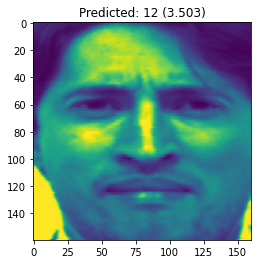

Predicted: 12 (3.503)
Expected: 12


In [85]:
# Show the image
plt.imshow(X_train[selection])
title = 'Predicted: %s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % rdm_name[0])

In [124]:
im=Image.open("C:/Users/Aaditya Saroj Rai/OneDrive/Pictures/Camera Roll/WIN_20211207_13_45_20_Pro.jpg")

In [125]:
rgb_pixels = np.stack((im, im, im), axis=2)

1/1 [==============================] - 0s 80ms/step


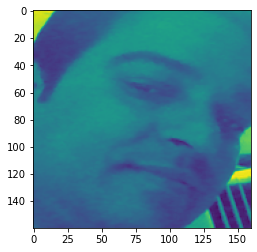

In [126]:
face_pixels = extract_face_from_file("C:/Users/Aaditya Saroj Rai/OneDrive/Pictures/Camera Roll/WIN_20211207_13_45_20_Pro.jpg")

plt.imshow(face_pixels)

In [128]:
results = detector.detect_faces(face_pixels)

ValueError: not enough values to unpack (expected 3, got 2)

In [120]:
face_pixels.shape

(160, 160)

In [ ]:
# Show the image
plt.imshow(X_train[selection])
title = 'Predicted: %s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % rdm_name[0])

In [82]:
df

,subject,category_centerlight,category_gif,category_glasses,category_happy,category_leftlight,category_noglasses,category_normal,category_rightlight,category_sad,...,filename_subject15.glasses,filename_subject15.happy,filename_subject15.leftlight,filename_subject15.noglasses,filename_subject15.normal,filename_subject15.rightlight,filename_subject15.sad,filename_subject15.sleepy,filename_subject15.surprised,filename_subject15.wink
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,15,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
162,15,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
163,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
164,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [1]:
import cv2
from deepface import DeepFace

emotions = {
    "angry": 0,
    "disgust": 0,
    "fear": 0,
    "happy": 0,
    "sad": 0,
    "surprise": 0,
    "neutral": 0
}


def start_analyzing_mimic():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(1)

    if not cap.isOpened():
        cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("No camera detected")

    while True:
        ret, frame = cap.read()
        result_analyzer = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        font = cv2.FONT_HERSHEY_PLAIN
        print('Dominant Facial Expression {0}'.format(result_analyzer['dominant_emotion']))
        analyze_expressions(result_analyzer['emotion'])

        cv2.putText(frame, result_analyzer['dominant_emotion'], (50, 50), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.imshow('Original video', frame)

        if cv2.waitKey(2) & 0xFF == ord('q'):
            report_expressions()
            break

    cap.release()
    cv2.destroyAllWindows()


def analyze_expressions(emotion):
    for key in emotion:
        emotions[key] = emotions[key] + emotion[key];

def report_expressions():
    total = 0;
    print("##### Facial Expression Report #####")
    print(emotions)
    for key in emotions:
        total += emotions[key];
    for key in emotions:
        percentage = emotions[key] * 100 / total;
        #print(key)
        #print(percentage)
        print('{0} => % {1}'.format(key, round(percentage, 2)))


if __name__ == '__main__':
    start_analyzing_mimic()

1/1 [==============================] - 5s 5s/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 48ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 48ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 51ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 48ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 48ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 54ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 50ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 46ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 50ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 49ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 49m

1/1 [==============================] - 0s 31ms/step
Dominant Facial Expression sad
1/1 [==============================] - 0s 16ms/step
Dominant Facial Expression angry
1/1 [==============================] - 0s 16ms/step
Dominant Facial Expression surprise
1/1 [==============================] - 0s 2ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 19ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 17ms/step
Dominant Facial Expression fear
1/1 [==============================] - 0s 17ms/step
Dominant Facial Expression fear
1/1 [==============================] - 0s 18ms/step
Dominant Facial Expression fear
1/1 [==============================] - 0s 32ms/step
Dominant Facial Expression fear
1/1 [==============================] - 0s 25ms/step
Dominant Facial Expression surprise
1/1 [==============================] - 0s 14ms/step
Dominant Facial Expression neutral
1/1 [==============================] - 0s 9ms/step
Dominant 

KeyboardInterrupt: 

In [130]:
pip install deepface



     -------------------------------------- 65.0/65.0 kB 702.6 kB/s eta 0:00:00
     -------------------------------------- 87.7/87.7 kB 710.5 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=6a4021f794bf39e53629bdc8a5cdcafd49f4c1dc82315ed458a53aef0a2b06b8
  Stored in directory: c:\users\aaditya saroj rai\appdata\local\pip\cache\wheels\2a\93\86\8cd17bc6c40fb605c3ac549d0b860ef7e84ee5f67bf01a3287
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=0cb5e6d8cfc8ab8be5fa4f2c177c35c0